# Efficient Bayesian Coresets

## Tests for individual algorithms

---

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
from ebc.sequential.non_iterative import SensitivityBasedIS
from ebc.sequential.iterative_with_convexification import SensitivityBasedFW
from ebc.sequential.iterative_no_convexification import SparseVI, GIGA, IHT
from ebc.parallel.parallel_iterative_with_convexification import ParallelSensitivityBasedFW
from ebc.gaussian import fisher_norm_under_true_gaussian_posterior, gaussian_multivariate_log_likelihood, gaussian_KL

In [6]:
# Generate Data
d = 20
N = 1000

np.random.seed(123)

# Theta as in sparse_vi
theta = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d))

# x as in sparse_vi
x = np.random.multivariate_normal(mean = theta, cov = np.identity(d), size = N)

# Parameters
sigma_0 = np.identity(d)
sigma = np.identity(d)
mu_0 = np.zeros(d).reshape(-1, 1)

# Full Gaussian posterior
sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))        

In [7]:
print(f"x: {x.shape}")
print(f"mu: {mu_0.shape}")

x: (1000, 20)
mu: (20, 1)


In [8]:
def log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return np.diag(gaussian_multivariate_log_likelihood(X.T, mu, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [9]:
likelihood_gram_matrix = fisher_norm_under_true_gaussian_posterior(x.T, x.T, mu_0, N)

In [10]:
from sklearn.decomposition import PCA

def plot_points(points, indices, w):
    pca = PCA(n_components = 2)
    vecs = pca.fit_transform(points)
    plt.scatter(vecs[indices, 0], vecs[indices, 1], 
                  s = w.flatten()[indices] * 50, alpha = 0.5)
    vecs = np.delete(vecs, indices, axis = 0)
    plt.scatter(vecs[:, 0], vecs[:, 1], alpha = 0.5, label = "NOT in coreset")
    plt.title("Points")
    plt.ylabel("PCA2")
    plt.xlabel("PCA1")
    plt.grid()
    plt.legend()
    
def plot_results(fkl, bkl, points, indices, w):
    fig, ax = plt.subplots(1, 3, figsize = (20, 5))
    ax[0].plot(fkl)
    ax[0].set_title("FKL")
    ax[0].set_ylabel("FKL")
    ax[0].set_xlabel("Coreset Size")
    ax[0].grid()
    
    ax[1].plot(fkl)
    ax[1].set_title("BKL")
    ax[1].set_ylabel("BKL")
    ax[1].set_xlabel("Coreset Size")
    ax[1].grid()
    
    pca = PCA(n_components = 2)
    vecs = pca.fit_transform(points)
    ax[2].scatter(vecs[indices, 0], vecs[indices, 1], 
                  s = w.flatten()[indices] * 50, alpha = 0.5)
    vecs = np.delete(vecs, indices, axis = 0)
    ax[2].scatter(vecs[:, 0], vecs[:, 1], alpha = 0.5, label = "NOT in coreset")
    ax[2].set_title("Points")
    ax[2].set_ylabel("PCA2")
    ax[2].set_xlabel("PCA1")
    ax[2].grid()
    ax[2].legend()
    
    #for ind in indices:
    #    ax[2].annotate(round(w.flatten()[ind]), (vecs[ind, 0], vecs[ind, 1]))

### 1.1. Sensitivity-Based IS

#### 1.1.1 True (Fisher) norm

In [11]:
fkl = []
bkl = []

for i in range(1, 90):
    sbis = SensitivityBasedIS(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = sbis.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

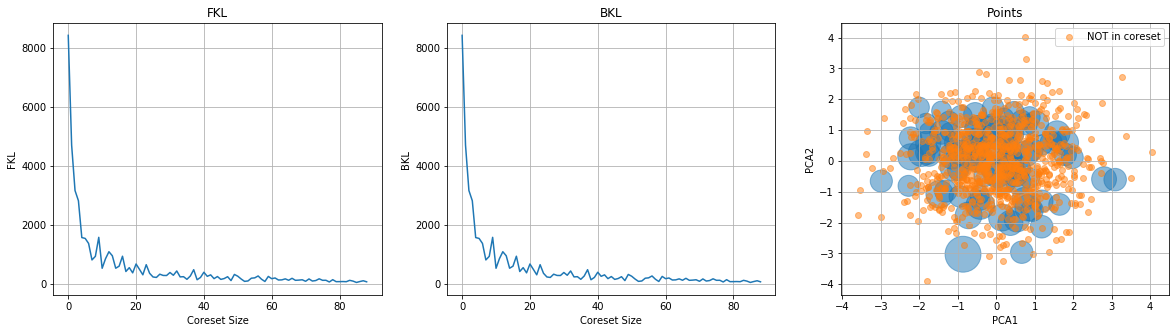

In [12]:
plot_results(fkl, bkl, x, I, w)

#### 1.1.2. Estimated norm

In [15]:
fkl = []
bkl = []

for i in range(1, 90, 10):
    sbis = SensitivityBasedIS(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = sbis.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

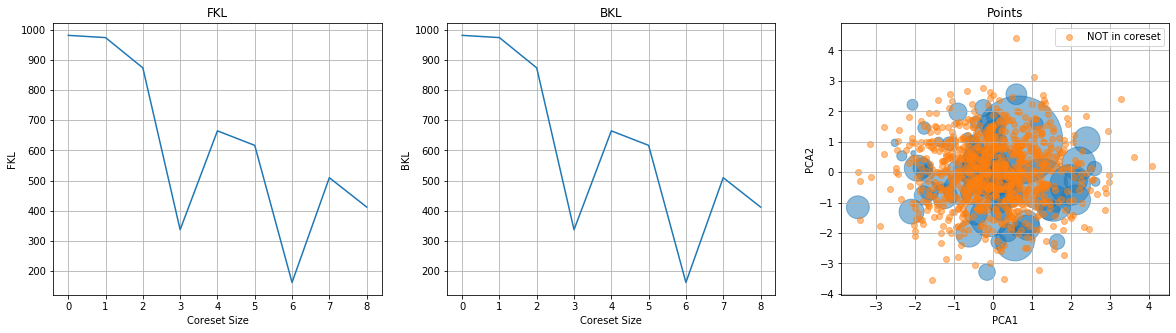

In [16]:
plot_results(fkl, bkl, x, I, w)

### 1.2. Sensitivity-Based FW

#### 1.2.1. True (Fisher) norm

In [167]:
fkl = []
bkl = []

for i in range(1, 90):
    sbfw = SensitivityBasedFW(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": int(0.3 * len(x))}
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

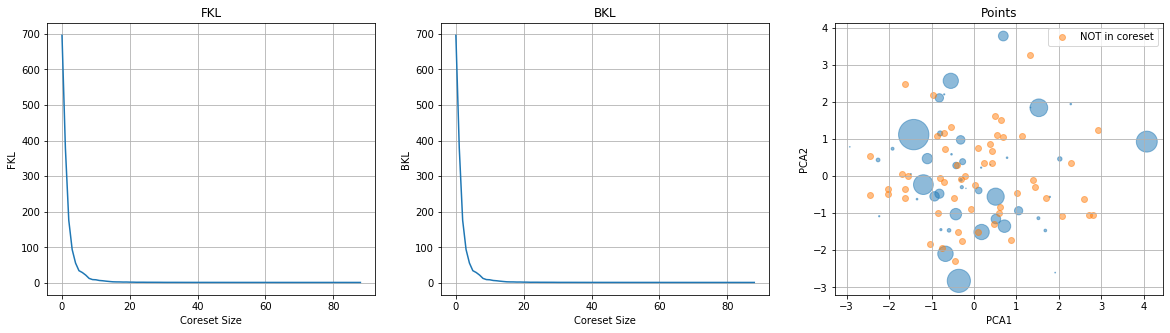

In [168]:
plot_results(fkl, bkl, x, I, w)

#### 1.2.2. Estimated norm

In [169]:
fkl = []
bkl = []

for i in range(1, 90):
    sbfw = SensitivityBasedFW(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": int(0.3 * len(x))}
    w, I = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

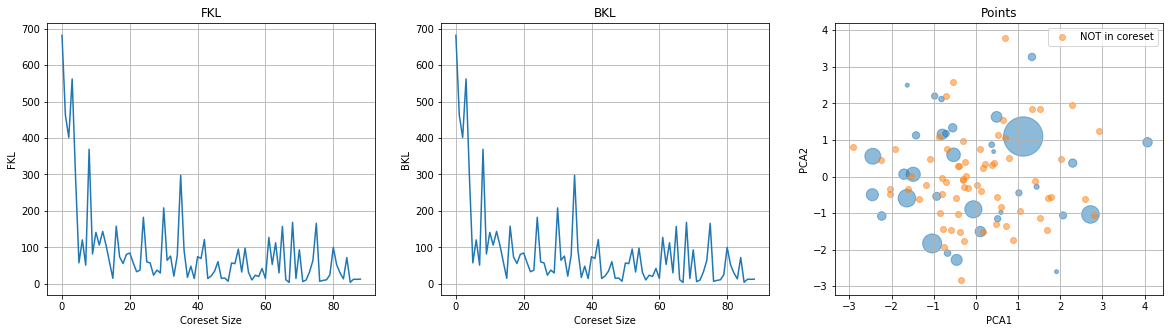

In [170]:
plot_results(fkl, bkl, x, I, w)

### 1.3. GIGA

#### 1.3.1. True (Fisher) norm

None

#### 1.3.2. Estimated norm

In [9]:
from ebc.approximations import random_kitchen_sinks
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                         np.ones(2 * d), 1000, norm = "2", MCMC_subs_size = 100)

In [10]:
fkl = []
bkl = []

for i in range(1, 90):
    giga = GIGA(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 1000,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

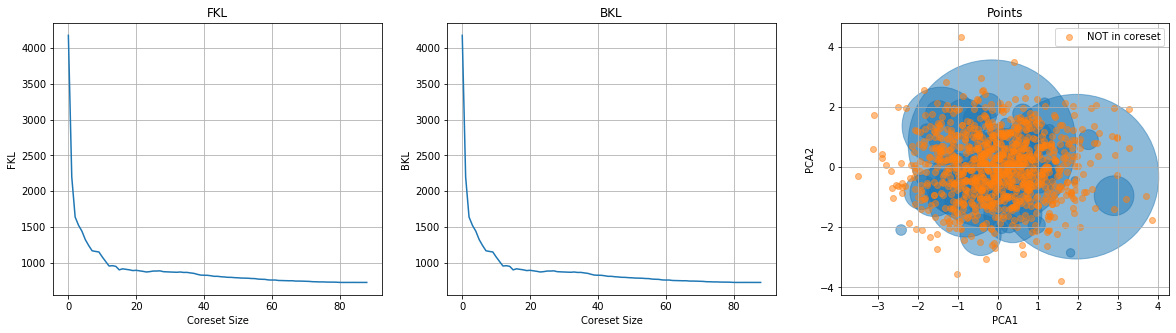

In [11]:
plot_results(fkl, bkl, x, I, w)

### 1.4. SparseVI

#### 1.4.1. True (Fisher) norm

In [184]:
fkl = []
bkl = []

for i in range(1, 90):
    def log_posterior(params, X, y, weights):
        return np.sum(log_likelihood(params, X, y, weights))

    svi = SparseVI(x)
    na = {"log_likelihood": log_likelihood,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.ones(2 * d),
          "S": 150,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "MCMC"}

    w, I = svi.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, 
                   norm_attributes = na, T = 100, gamma_func = lambda x : 1 / x)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

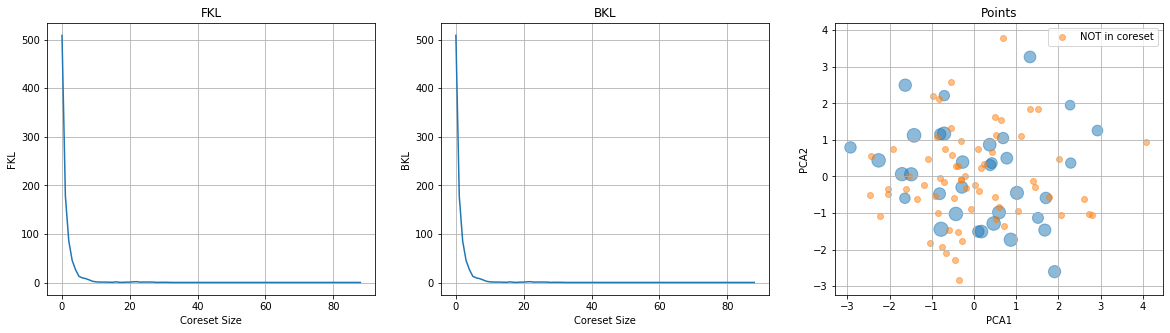

In [185]:
plot_results(fkl, bkl, x, I, w)

#### 1.4.2. Estimated norm

In [182]:
fkl = []
bkl = []

for i in range(1, 90):
    def log_posterior(params, X, y, weights):
        return np.sum(log_likelihood(params, X, y, weights))

    svi = SparseVI(x)
    na = {"log_likelihood": log_likelihood,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.ones(2 * d),
          "S": 150,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "MCMC"}

    w, I = svi.run(k = i, likelihood_gram_matrix = None, 
                   norm_attributes = na, T = 100, gamma_func = lambda x : 1 / x)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

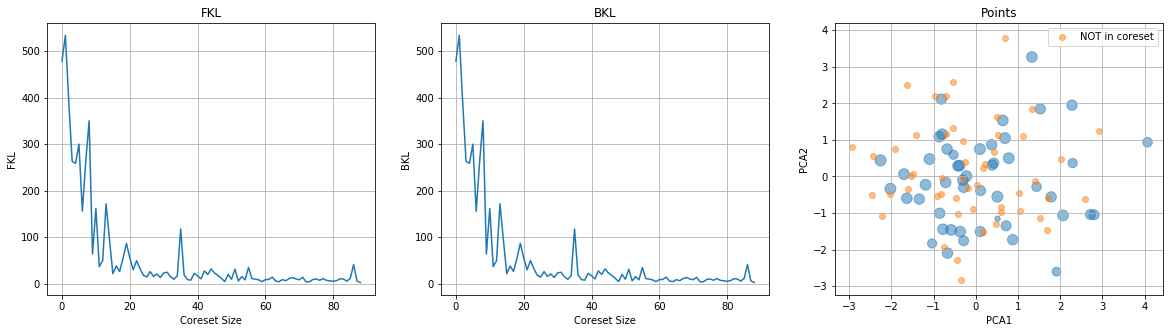

In [183]:
plot_results(fkl, bkl, x, I, w)

### 1.5. Iterative Hard Thresholding

In [14]:
from approximations import random_kitchen_sinks
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                         np.ones(2 * d), 500, norm = "2", MCMC_subs_size = 100)

In [15]:
fkl = []
bkl = []

for i in range(1, 500, 10):
    iht = IHT(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = iht.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

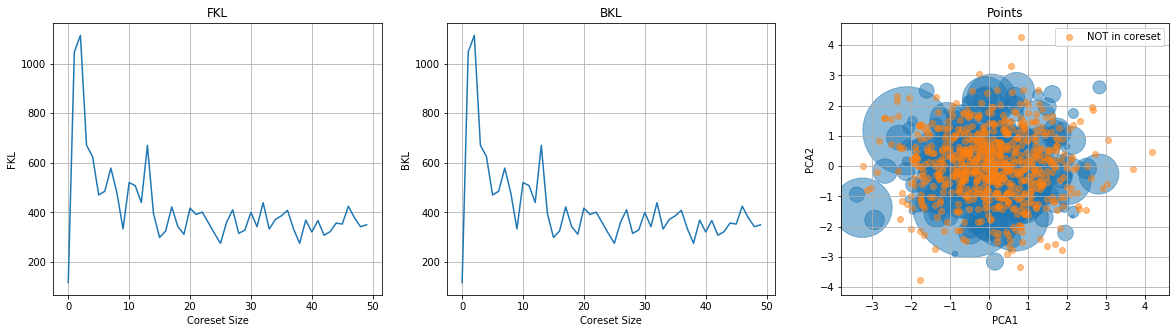

In [16]:
plot_results(fkl, bkl, x, I, w)

---
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from non_iterative import SensitivityBasedIS
from gaussian import fisher_norm_under_true_gaussian_posterior, gaussian_multivariate_log_likelihood, gaussian_KL
from metrics import gaussian_KL

## 1. Multivariate Gaussian

$$
\mu \in \mathbb{R}^D \sim \mathcal{N}(0, 1)
$$

$$
X_{n \times d} \sim \mathcal{N}(\mu, 1)
$$

In [2]:
# Generate Data
N = 100
d = 20

np.random.seed(123)

# Mean value
theta = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d))

# X_{n x d}
x = np.random.multivariate_normal(mean = theta, cov = np.identity(d), size = N)

# Start values
sigma_0 = np.identity(d)
sigma = np.identity(d)
mu_0 = np.zeros(d).reshape(-1, 1)

# Full Gaussian posterior
sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))

# Likelihood exact gram matrix
likelihood_gram_matrix = fisher_norm_under_true_gaussian_posterior(x.T, x.T, mu_0, N)

def log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return np.diag(gaussian_multivariate_log_likelihood(X.T, mu, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

print(f"x: {x.shape}")
print(f"mu: {mu_0.shape}")

x: (100, 20)
mu: (20, 1)


In [3]:
from non_iterative import SensitivityBasedIS
from iterative_with_convexification import SensitivityBasedFW
from iterative_no_convexification import SparseVI

### 1.1. IS with different norms

In [9]:
norms = ["uniform", "2", "F"]
apr = ["Laplace", "MCMC"]

fkls = []
bkls = []

for n in range(len(norms)):
    for k in range(len(apr)):
        print(f"{n}-{k}")
        fkl = []
        bkl = []
        for i in range(1, 90):
            sbis = SensitivityBasedIS(x)
            
            na = {"log_likelihood": log_likelihood,
              "log_likelihood_start_value": np.ones(2 * d),
              "S": 150,
              "log_likelihood_gradient": grad_log_likelihood,
              "approx": apr[k],
              "num_clusters": 3,
              "R": 1,
              "MCMC_subs_size": 30}
            
            w, I = sbis.run(k = i, likelihood_gram_matrix = None, norm = norms[n], norm_attributes = na)

            # Calculate posterior approximation
            sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
            mu_hat = sigma_hat @ (mu_0 + x.T @ w)

            fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
            bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
            
        fkls.append(fkl)
        bkls.append(bkl)

0-0
0-1
1-0
1-1
2-0
2-1


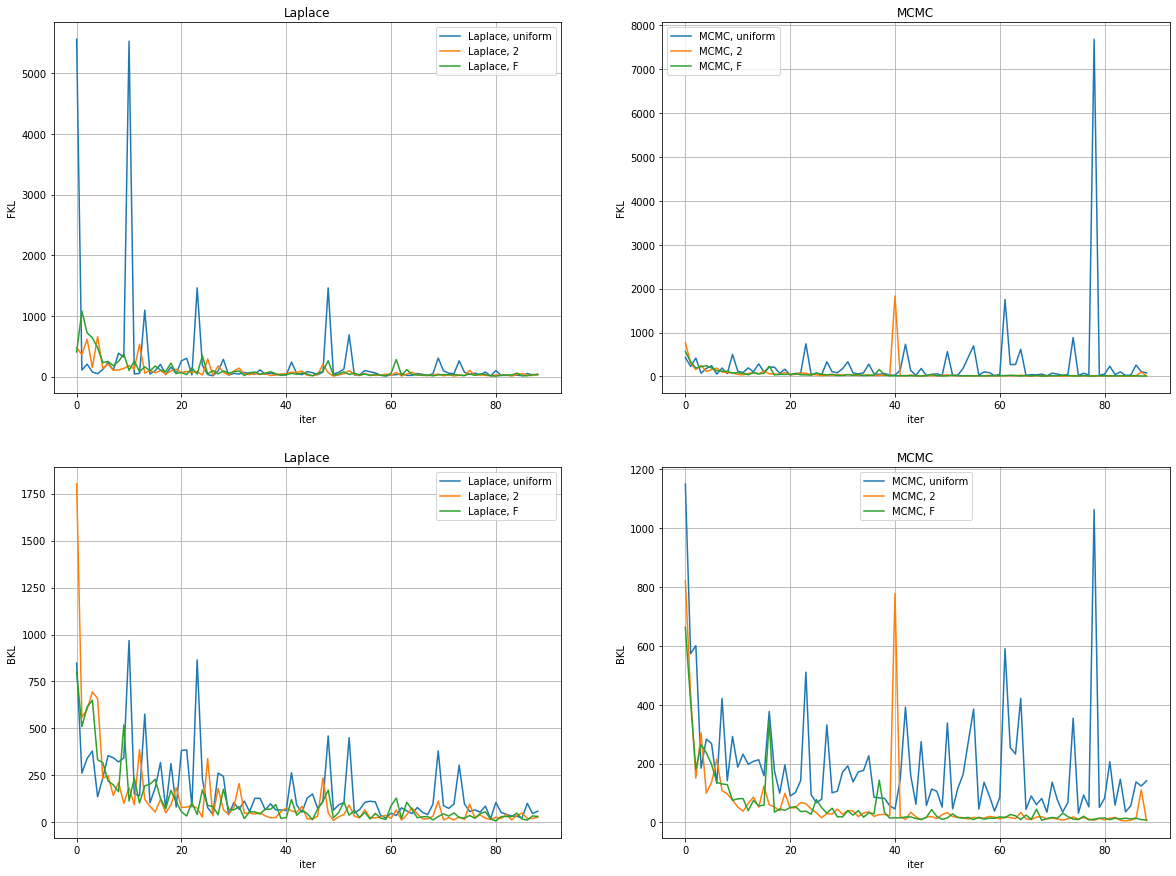

In [19]:
fig, ax = plt.subplots(2, 2, figsize = (20, 15))

ax[0, 0].plot(fkls[0], label = "Laplace, uniform")
ax[0, 0].plot(fkls[2], label = "Laplace, 2")
ax[0, 0].plot(fkls[4], label = "Laplace, F")
ax[0, 0].set_ylabel("FKL")
ax[0, 0].set_xlabel("iter")
ax[0, 0].set_title("Laplace")

ax[0, 1].plot(fkls[1], label = "MCMC, uniform")
ax[0, 1].plot(fkls[3], label = "MCMC, 2")
ax[0, 1].plot(fkls[5], label = "MCMC, F")
ax[0, 1].set_ylabel("FKL")
ax[0, 1].set_xlabel("iter")
ax[0, 1].set_title("MCMC")

ax[1, 0].plot(bkls[0], label = "Laplace, uniform")
ax[1, 0].plot(bkls[2], label = "Laplace, 2")
ax[1, 0].plot(bkls[4], label = "Laplace, F")
ax[1, 0].set_ylabel("BKL")
ax[1, 0].set_xlabel("iter")
ax[1, 0].set_title("Laplace")

ax[1, 1].plot(bkls[1], label = "MCMC, uniform")
ax[1, 1].plot(bkls[3], label = "MCMC, 2")
ax[1, 1].plot(bkls[5], label = "MCMC, F")
ax[1, 1].set_ylabel("BKL")
ax[1, 1].set_xlabel("iter")
ax[1, 1].set_title("MCMC")

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

ax[0, 0].grid()
ax[0, 1].grid()
ax[1, 0].grid()
ax[1, 1].grid()

### 1.2. FW with different norms

In [5]:
norms = ["2", "F"]
apr = ["Laplace", "MCMC"]

fkls = []
bkls = []

for n in range(len(norms)):
    for k in range(len(apr)):
        print(f"{n}-{k}")
        fkl = []
        bkl = []
        for i in range(1, 90):
            sbis = SensitivityBasedFW(x)
            
            na = {"log_likelihood": log_likelihood,
              "log_likelihood_start_value": np.ones(2 * d),
              "S": 150,
              "log_likelihood_gradient": grad_log_likelihood,
              "approx": apr[k],
              "num_clusters": 3,
              "R": 1,
              "MCMC_subs_size": 30}
            
            w, I = sbis.run(k = i, likelihood_gram_matrix = None, norm = norms[n], norm_attributes = na)

            # Calculate posterior approximation
            sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
            mu_hat = sigma_hat @ (mu_0 + x.T @ w)

            fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
            bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
            
        fkls.append(fkl)
        bkls.append(bkl)

0-0
0-1
1-0
1-1


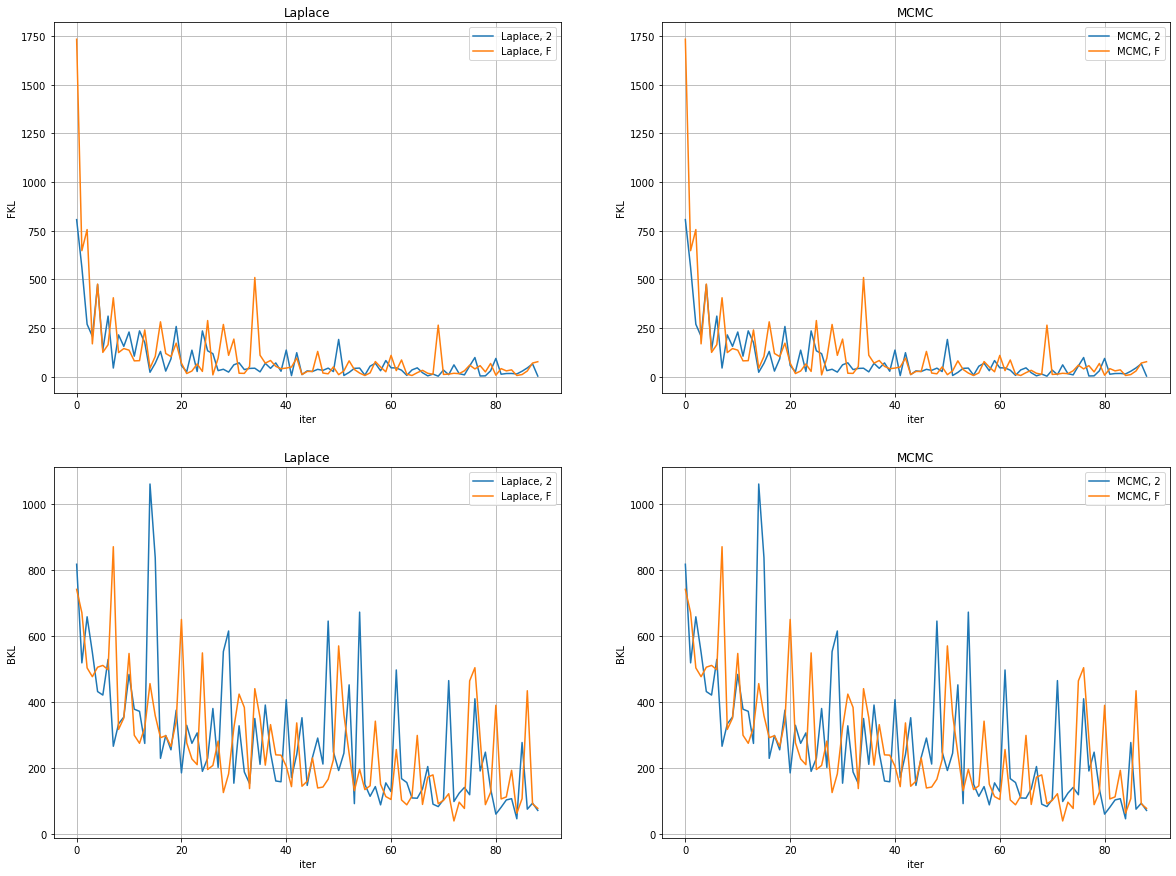

In [6]:
fig, ax = plt.subplots(2, 2, figsize = (20, 15))

ax[0, 0].plot(fkls[0], label = "Laplace, 2")
ax[0, 0].plot(fkls[2], label = "Laplace, F")
ax[0, 0].set_ylabel("FKL")
ax[0, 0].set_xlabel("iter")
ax[0, 0].set_title("Laplace")

ax[0, 1].plot(fkls[0], label = "MCMC, 2")
ax[0, 1].plot(fkls[2], label = "MCMC, F")
ax[0, 1].set_ylabel("FKL")
ax[0, 1].set_xlabel("iter")
ax[0, 1].set_title("MCMC")

ax[1, 0].plot(bkls[1], label = "Laplace, 2")
ax[1, 0].plot(bkls[3], label = "Laplace, F")
ax[1, 0].set_ylabel("BKL")
ax[1, 0].set_xlabel("iter")
ax[1, 0].set_title("Laplace")

ax[1, 1].plot(bkls[1], label = "MCMC, 2")
ax[1, 1].plot(bkls[3], label = "MCMC, F")
ax[1, 1].set_ylabel("BKL")
ax[1, 1].set_xlabel("iter")
ax[1, 1].set_title("MCMC")

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

ax[0, 0].grid()
ax[0, 1].grid()
ax[1, 0].grid()
ax[1, 1].grid()

### 1.3. FW with true vs estimated posterior

In [9]:
norms = ["F"]
apr = ["Laplace", "MCMC"]

fkls = []
bkls = []

for n in range(len(norms)):
    for k in range(len(apr)):
        print(f"{n}-{k}")
        fkl = []
        bkl = []
        for i in range(1, 90):
            sbis = SensitivityBasedFW(x)
            
            na = {"log_likelihood": log_likelihood,
              "log_likelihood_start_value": np.ones(2 * d),
              "S": 150,
              "log_likelihood_gradient": grad_log_likelihood,
              "approx": apr[k],
              "num_clusters": 3,
              "R": 1,
              "MCMC_subs_size": 30}
            
            w, I = sbis.run(k = i, likelihood_gram_matrix = None, norm = norms[n], norm_attributes = na)

            # Calculate posterior approximation
            sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
            mu_hat = sigma_hat @ (mu_0 + x.T @ w)

            fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
            bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
            
        fkls.append(fkl)
        bkls.append(bkl)

0-0
0-1


In [10]:
fkl = []
bkl = []

for i in range(1, 90):
        sbis = SensitivityBasedFW(x)

        na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.ones(2 * d),
          "S": 150,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": apr[k],
          "num_clusters": 3,
          "R": 1,
          "MCMC_subs_size": 30}

        w, I = sbis.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, 
                        norm = "F", norm_attributes = na)

        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w)

        fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
        bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

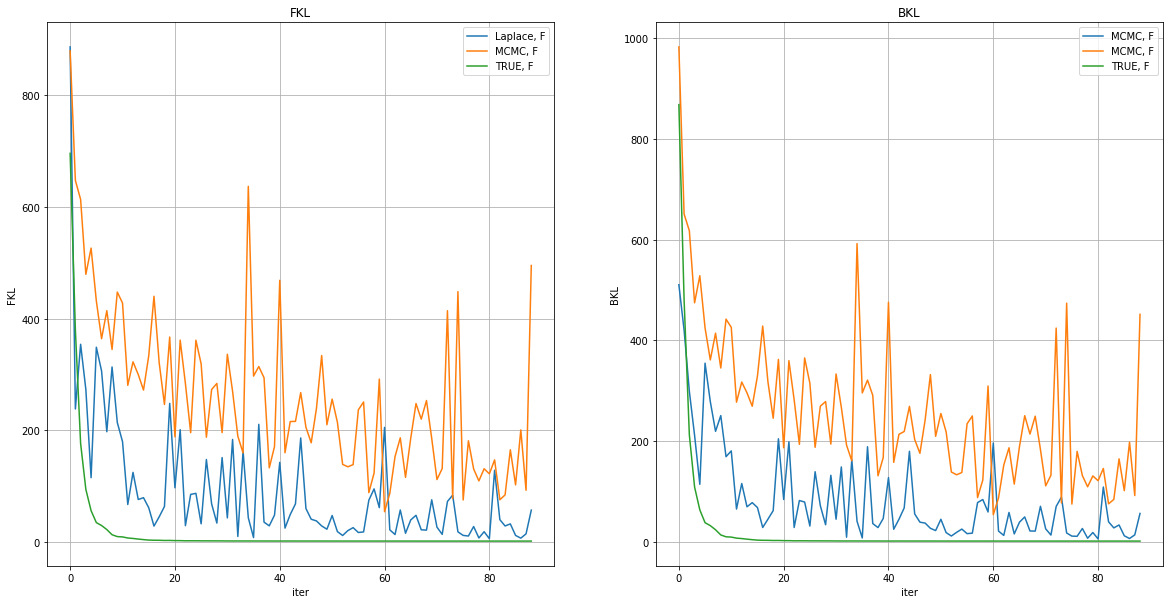

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

ax[0].plot(fkls[0], label = "Laplace, F")
ax[0].plot(fkls[1], label = "MCMC, F")
ax[0].plot(fkl, label = "TRUE, F")
ax[0].set_ylabel("FKL")
ax[0].set_xlabel("iter")
ax[0].set_title("FKL")

ax[1].plot(bkls[0], label = "MCMC, F")
ax[1].plot(bkls[1], label = "MCMC, F")
ax[1].plot(bkl, label = "TRUE, F")
ax[1].set_ylabel("BKL")
ax[1].set_xlabel("iter")
ax[1].set_title("BKL")

ax[0].legend()
ax[1].legend()

ax[0].grid()
ax[1].grid()

### 1.4. GIGA with different vector lengths

* S = 500

In [190]:
np.random.seed(123)
from approximations import random_kitchen_sinks
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                         np.ones(2 * d), 500, norm = "2", MCMC_subs_size = 100)

In [191]:
fkl = []
bkl = []

for i in range(1, 90):
    giga = GIGA(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 1000,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

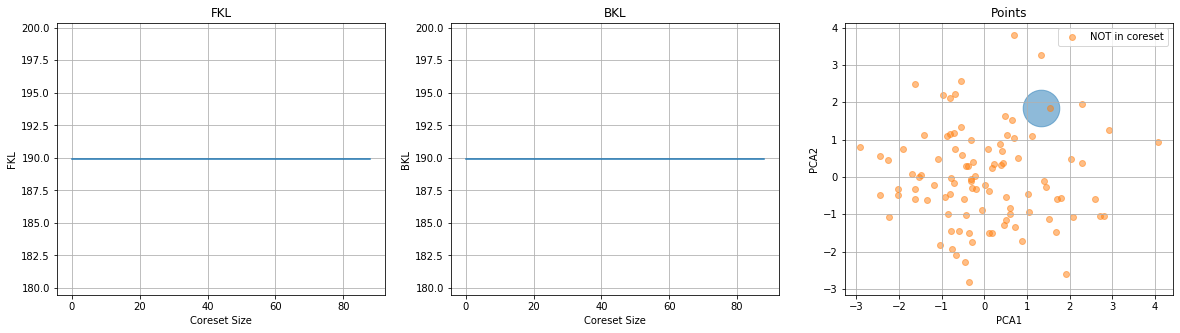

In [192]:
plot_results(fkl, bkl, x, I, w)

* S = 1000

In [193]:
np.random.seed(123)
from approximations import random_kitchen_sinks
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                         np.ones(2 * d), 1000, norm = "2", MCMC_subs_size = 100)

In [194]:
fkl = []
bkl = []

for i in range(1, 90):
    giga = GIGA(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 1000,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

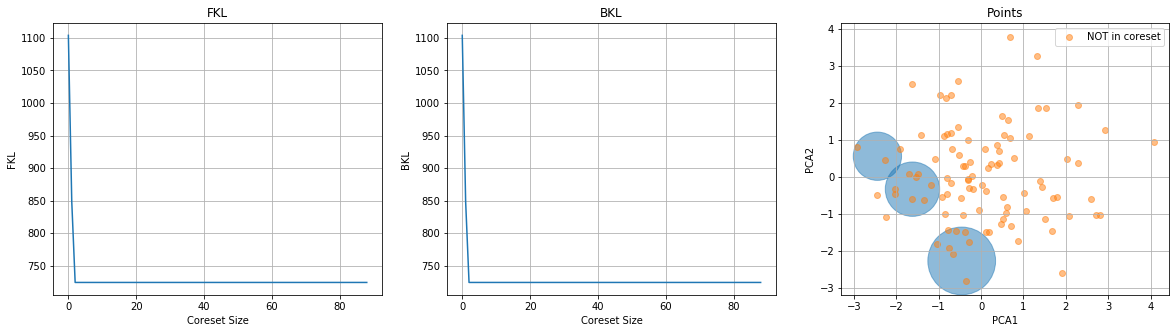

In [195]:
plot_results(fkl, bkl, x, I, w)

* S = 5000

In [196]:
np.random.seed(123)
from approximations import random_kitchen_sinks
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                         np.ones(2 * d), 5000, norm = "2", MCMC_subs_size = 100)

In [197]:
fkl = []
bkl = []

for i in range(1, 90):
    giga = GIGA(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 1000,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

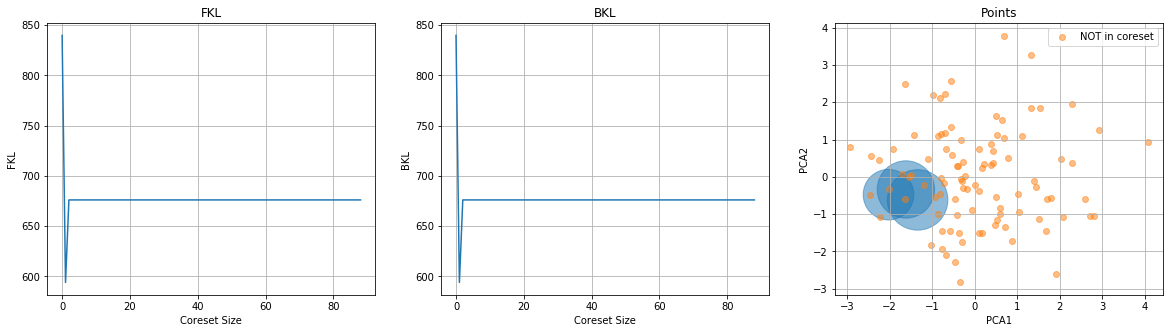

In [198]:
plot_results(fkl, bkl, x, I, w)

* S = 10000

In [199]:
np.random.seed(123)
from approximations import random_kitchen_sinks
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                         np.ones(2 * d), 10000, norm = "2", MCMC_subs_size = 100)

In [200]:
fkl = []
bkl = []

for i in range(1, 90):
    giga = GIGA(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 1000,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

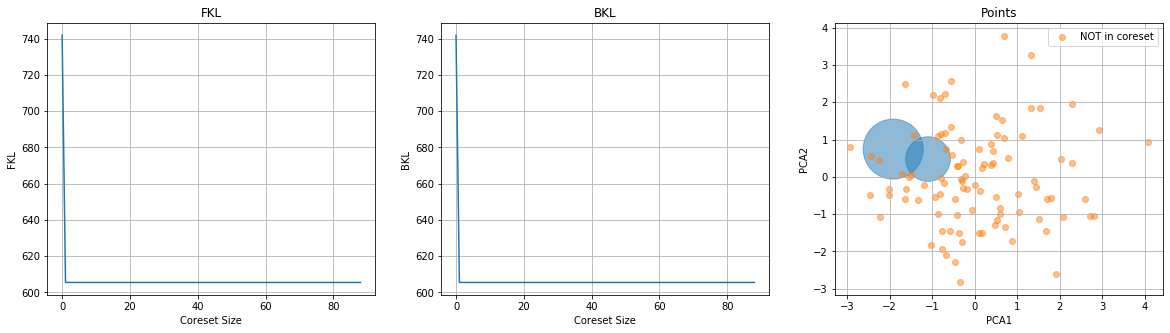

In [201]:
plot_results(fkl, bkl, x, I, w)

### 1.5 Comparison of all algorithms

In [245]:
fkl = np.zeros((29, 4))
bkl = np.zeros((29, 4))

na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 500,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "MCMC",
      "MCMC_subs_size": 100,
      "log_posterior": log_posterior,
      "log_posterior_start_value": np.ones(2 * d)}

for i in range(1, 30):
    sbis = SensitivityBasedIS(x)
    sbfw = SensitivityBasedFW(x)
    giga = GIGA(x)
    svi = SparseVI(x)
    w1, I1 = sbis.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    w2, I2 = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    w3, I3 = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
    w4, I4 = svi.run(k = i, likelihood_gram_matrix = None, 
                     norm_attributes = na, T = 100, gamma_func = lambda x : 1 / x)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w1)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w1)

    fkl[i-1, 0] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[i-1, 0] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w2)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w2)

    fkl[i-1, 1] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[i-1, 1] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w3)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w3)

    fkl[i-1, 2] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[i-1, 2] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w4)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w4)

    fkl[i-1, 3] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[i-1, 3] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)

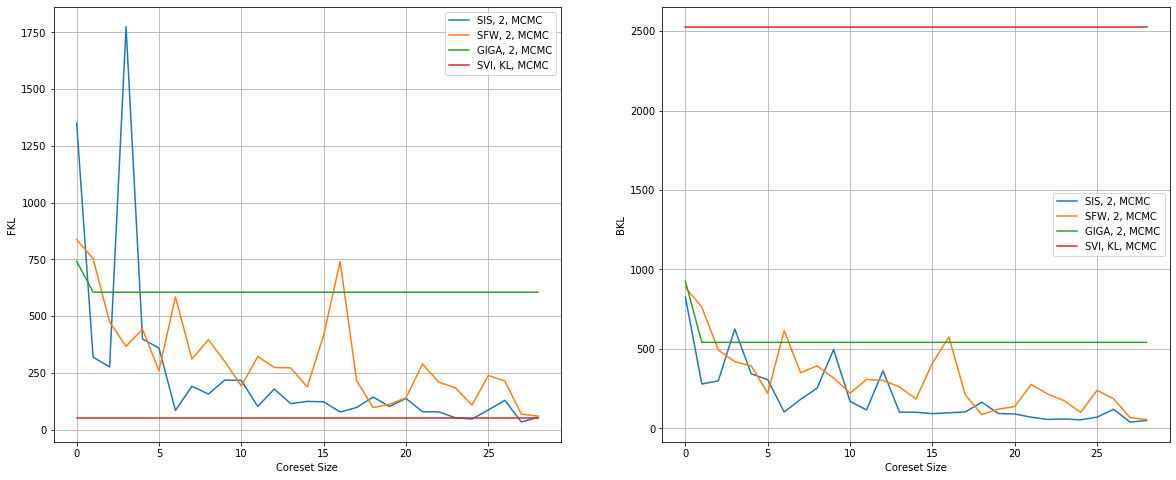

In [246]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(fkl[:, 0], label = 'SIS, 2, MCMC')
ax[0].plot(fkl[:, 1], label = 'SFW, 2, MCMC')
ax[0].plot(fkl[:, 2], label = 'GIGA, 2, MCMC')
ax[0].plot(fkl[:, 3], label = 'SVI, KL, MCMC')
ax[0].legend()
ax[0].set_xlabel("Coreset Size")
ax[0].set_ylabel("FKL")
ax[0].grid()

ax[1].plot(bkl[:, 0], label = 'SIS, 2, MCMC')
ax[1].plot(bkl[:, 1], label = 'SFW, 2, MCMC')
ax[1].plot(bkl[:, 2], label = 'GIGA, 2, MCMC')
ax[1].plot(bkl[:, 3], label = 'SVI, KL, MCMC')
ax[1].legend()
ax[1].set_xlabel("Coreset Size")
ax[1].set_ylabel("BKL")
ax[1].grid()

### 1.6. Parallelization hypothesis

In [7]:
fkl = []
bkl = []

for i in range(1, 90):
    print(f"iteration = {i}")
    sbfw = SensitivityBasedFW(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": int(0.3 * len(x))}
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    print('==============\n')

iteration = 1

iteration = 2
DIREC
[83 32 79 27 30]
END DIREC
self.I: [77, 83]

iteration = 3
DIREC
[83 32 79 27 30]
END DIREC
self.I: [77, 83]
DIREC
[20 47 27 71 85]
END DIREC
self.I: [77, 83, 20]

iteration = 4
DIREC
[83 32 79 27 30]
END DIREC
self.I: [77, 83]
DIREC
[20 47 27 71 85]
END DIREC
self.I: [77, 83, 20]
DIREC
[28  3 47 31  0]
END DIREC
self.I: [77, 83, 20, 28]

iteration = 5
DIREC
[83 32 79 27 30]
END DIREC
self.I: [77, 83]
DIREC
[20 47 27 71 85]
END DIREC
self.I: [77, 83, 20]
DIREC
[28  3 47 31  0]
END DIREC
self.I: [77, 83, 20, 28]
DIREC
[ 0 31 21 54 94]
END DIREC
self.I: [77, 83, 20, 28, 0]

iteration = 6
DIREC
[83 32 79 27 30]
END DIREC
self.I: [77, 83]
DIREC
[20 47 27 71 85]
END DIREC
self.I: [77, 83, 20]
DIREC
[28  3 47 31  0]
END DIREC
self.I: [77, 83, 20, 28]
DIREC
[ 0 31 21 54 94]
END DIREC
self.I: [77, 83, 20, 28, 0]
DIREC
[89 27 47 61 21]
END DIREC
self.I: [77, 83, 20, 28, 0, 89]

iteration = 7
DIREC
[83 32 79 27 30]
END DIREC
self.I: [77, 83]
DIREC
[20 47 27 71 

[27 21 14  6 26]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27]
DIREC
[ 6 45 30 91 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6]
DIREC
[31 94 91 51 39]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31]
DIREC
[34 45 16 30 87]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34]
DIREC
[94 14 98 51 96]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94]
DIREC
[60 30  6 87 35]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60]
DIREC
[35 30 57 45 95]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35]
DIREC
[30  8 40 14 51]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30]
DIREC
[71 14 41 40 94]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71]
DIREC
[14 21 45 40 95]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14]
DIREC
[ 8 45 16 44  6]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8]
DIREC
[45  6 40  5 57]
END DIREC
self.

DIREC
[ 6 45 30 91 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6]
DIREC
[31 94 91 51 39]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31]
DIREC
[34 45 16 30 87]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34]
DIREC
[94 14 98 51 96]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94]
DIREC
[60 30  6 87 35]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60]
DIREC
[35 30 57 45 95]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35]
DIREC
[30  8 40 14 51]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30]
DIREC
[71 14 41 40 94]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71]
DIREC
[14 21 45 40 95]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14]
DIREC
[ 8 45 16 44  6]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8]
DIREC
[45  6 40  5 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 1

DIREC
[83 32 79 27 30]
END DIREC
self.I: [77, 83]
DIREC
[20 47 27 71 85]
END DIREC
self.I: [77, 83, 20]
DIREC
[28  3 47 31  0]
END DIREC
self.I: [77, 83, 20, 28]
DIREC
[ 0 31 21 54 94]
END DIREC
self.I: [77, 83, 20, 28, 0]
DIREC
[89 27 47 61 21]
END DIREC
self.I: [77, 83, 20, 28, 0, 89]
DIREC
[27 21 14  6 26]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27]
DIREC
[ 6 45 30 91 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6]
DIREC
[31 94 91 51 39]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31]
DIREC
[34 45 16 30 87]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34]
DIREC
[94 14 98 51 96]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94]
DIREC
[60 30  6 87 35]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60]
DIREC
[35 30 57 45 95]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35]
DIREC
[30  8 40 14 51]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30]
DIREC
[71 14 41 40 94]
END DIREC
self.I: [77, 83, 20, 2

[41 71 39 22 40]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41]

iteration = 48
DIREC
[83 32 79 27 30]
END DIREC
self.I: [77, 83]
DIREC
[20 47 27 71 85]
END DIREC
self.I: [77, 83, 20]
DIREC
[28  3 47 31  0]
END DIREC
self.I: [77, 83, 20, 28]
DIREC
[ 0 31 21 54 94]
END DIREC
self.I: [77, 83, 20, 28, 0]
DIREC
[89 27 47 61 21]
END DIREC
self.I: [77, 83, 20, 28, 0, 89]
DIREC
[27 21 14  6 26]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27]
DIREC
[ 6 45 30 91 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6]
DIREC
[31 94 91 51 39]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31]
DIREC
[34 45 16 30 87]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34]
DIREC
[94 14 98 51 96]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94]
DIREC
[60 30  6 87 35]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60]
DIREC
[35 30 57 45 95]
END DIREC
self.I: [77, 8

DIREC
[ 3 89 22 28 70]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41, 70, 3]
DIREC
[22 71 40 43 78]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41, 70, 3, 22]

iteration = 53
DIREC
[83 32 79 27 30]
END DIREC
self.I: [77, 83]
DIREC
[20 47 27 71 85]
END DIREC
self.I: [77, 83, 20]
DIREC
[28  3 47 31  0]
END DIREC
self.I: [77, 83, 20, 28]
DIREC
[ 0 31 21 54 94]
END DIREC
self.I: [77, 83, 20, 28, 0]
DIREC
[89 27 47 61 21]
END DIREC
self.I: [77, 83, 20, 28, 0, 89]
DIREC
[27 21 14  6 26]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27]
DIREC
[ 6 45 30 91 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6]
DIREC
[31 94 91 51 39]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31]
DIREC
[34 45 16 30 87]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34]
DIREC
[94

self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88]
DIREC
[38 39 78 80 22]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88]
DIREC
[65 22 70  3 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88]
DIREC
[41 71 39 22 40]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41]
DIREC
[70 39  3 40 22]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41, 70]
DIREC
[38 40 39 71 78]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 

[83 32 79 27 30]
END DIREC
self.I: [77, 83]
DIREC
[20 47 27 71 85]
END DIREC
self.I: [77, 83, 20]
DIREC
[28  3 47 31  0]
END DIREC
self.I: [77, 83, 20, 28]
DIREC
[ 0 31 21 54 94]
END DIREC
self.I: [77, 83, 20, 28, 0]
DIREC
[89 27 47 61 21]
END DIREC
self.I: [77, 83, 20, 28, 0, 89]
DIREC
[27 21 14  6 26]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27]
DIREC
[ 6 45 30 91 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6]
DIREC
[31 94 91 51 39]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31]
DIREC
[34 45 16 30 87]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34]
DIREC
[94 14 98 51 96]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94]
DIREC
[60 30  6 87 35]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60]
DIREC
[35 30 57 45 95]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35]
DIREC
[30  8 40 14 51]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30]
DIREC
[71 14 41 40 94]
END DIREC
self.I: [77, 83, 20, 28, 0, 

END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41, 70, 3, 22, 1, 37, 4]
DIREC
[22  8  3 78 89]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41, 70, 3, 22, 1, 37, 4]

iteration = 66
DIREC
[83 32 79 27 30]
END DIREC
self.I: [77, 83]
DIREC
[20 47 27 71 85]
END DIREC
self.I: [77, 83, 20]
DIREC
[28  3 47 31  0]
END DIREC
self.I: [77, 83, 20, 28]
DIREC
[ 0 31 21 54 94]
END DIREC
self.I: [77, 83, 20, 28, 0]
DIREC
[89 27 47 61 21]
END DIREC
self.I: [77, 83, 20, 28, 0, 89]
DIREC
[27 21 14  6 26]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27]
DIREC
[ 6 45 30 91 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6]
DIREC
[31 94 91 51 39]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31]
DIREC
[34 45 16 30 87]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34]
DIREC
[9

DIREC
[83 32 79 27 30]
END DIREC
self.I: [77, 83]
DIREC
[20 47 27 71 85]
END DIREC
self.I: [77, 83, 20]
DIREC
[28  3 47 31  0]
END DIREC
self.I: [77, 83, 20, 28]
DIREC
[ 0 31 21 54 94]
END DIREC
self.I: [77, 83, 20, 28, 0]
DIREC
[89 27 47 61 21]
END DIREC
self.I: [77, 83, 20, 28, 0, 89]
DIREC
[27 21 14  6 26]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27]
DIREC
[ 6 45 30 91 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6]
DIREC
[31 94 91 51 39]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31]
DIREC
[34 45 16 30 87]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34]
DIREC
[94 14 98 51 96]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94]
DIREC
[60 30  6 87 35]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60]
DIREC
[35 30 57 45 95]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35]
DIREC
[30  8 40 14 51]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30]
DIREC
[71 14 41 40 94]
END DIREC
self.I: [77, 83, 20, 2

[18 65 30 87 95]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73]
DIREC
[44 30 65 59  8]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44]
DIREC
[87 65 38  6  5]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87]
DIREC
[65  6 81  5  8]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65]
DIREC
[38 40  8  5 67]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38]
DIREC
[ 5  8  6 21 88]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38]
DIREC
[ 8 41 53  6 86]
END DIREC
self.I: [77, 83, 

DIREC
[38  4 73  1 67]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41, 70, 3, 22, 1, 37, 4, 84]
DIREC
[73  1 22 89  5]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41, 70, 3, 22, 1, 37, 4, 84]
DIREC
[ 4 29 22 89  1]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41, 70, 3, 22, 1, 37, 4, 84]
DIREC
[22 57 86 41 29]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41, 70, 3, 22, 1, 37, 4, 84]
DIREC
[57  1 86 47 11]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87

DIREC
[44 30 65 59  8]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44]
DIREC
[87 65 38  6  5]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87]
DIREC
[65  6 81  5  8]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65]
DIREC
[38 40  8  5 67]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38]
DIREC
[ 5  8  6 21 88]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38]
DIREC
[ 8 41 53  6 86]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38]
DIREC
[57 41  6 86 40]
END D

DIREC
[57 41  6 86 40]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38]
DIREC
[67 21 47 88 40]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67]
DIREC
[21 53 39 41 40]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21]
DIREC
[53 39 28  4 37]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53]
DIREC
[88 39 28 38 40]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88]
DIREC
[38 39 78 80 22]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 

self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41, 70, 3, 22, 1, 37, 4, 84, 86, 29]
DIREC
[73 38 71 31 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41, 70, 3, 22, 1, 37, 4, 84, 86, 29]
DIREC
[38 39 31  4 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41, 70, 3, 22, 1, 37, 4, 84, 86, 29]
DIREC
[57 11  3 31 41]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39, 57, 81, 18, 47, 59, 40, 73, 44, 87, 65, 38, 67, 21, 53, 88, 41, 70, 3, 22, 1, 37, 4, 84, 86, 29]

iteration = 86
DIREC
[83 32 79 27 30]
END DIREC
self.I: [77, 83]
DIREC
[20 47 27 71 85]
END DIREC
self.I: [77, 83, 20]
DIREC
[28  3 47 31  0]
END DIREC
self

[71 14 41 40 94]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71]
DIREC
[14 21 45 40 95]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14]
DIREC
[ 8 45 16 44  6]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8]
DIREC
[45  6 40  5 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45]
DIREC
[ 5 21 95 81 79]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5]
DIREC
[95 18 41 53 16]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95]
DIREC
[39 16 53 37 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39]
DIREC
[ 8 53 37 86 57]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 45, 5, 95, 39]
DIREC
[57 18 86 37 53]
END DIREC
self.I: [77, 83, 20, 28, 0, 89, 27, 6, 31, 34, 94, 60, 35, 30, 71, 14, 8, 4

In [8]:
fkl = []
bkl = []

for i in range(1, 90):
    print(f"iteration = {i}")
    sbfw = SensitivityBasedFW(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": int(0.3 * len(x))}
    w, I = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    print('==============\n')

iteration = 1

iteration = 2
DIREC
[ 4  0 63 48 38]
END DIREC
self.I: [32, 4]

iteration = 3
DIREC
[ 5 94 67 95 92]
END DIREC
self.I: [66, 5]
DIREC
[92 52 58 36 98]
END DIREC
self.I: [66, 5, 92]

iteration = 4
DIREC
[38 48  3 71 72]
END DIREC
self.I: [29, 38]
DIREC
[52 23 72 14 35]
END DIREC
self.I: [29, 38, 52]
DIREC
[20 49 85 73 37]
END DIREC
self.I: [29, 38, 52, 20]

iteration = 5
DIREC
[60 27 98  2  1]
END DIREC
self.I: [68, 60]
DIREC
[98  2  1 33 32]
END DIREC
self.I: [68, 60, 98]
DIREC
[32  1 57 21 72]
END DIREC
self.I: [68, 60, 98, 32]
DIREC
[79 51 72 95 46]
END DIREC
self.I: [68, 60, 98, 32, 79]

iteration = 6
DIREC
[84 29 68 74 28]
END DIREC
self.I: [38, 84]
DIREC
[74 53 99 42 33]
END DIREC
self.I: [38, 84, 74]
DIREC
[72  1 87 25 52]
END DIREC
self.I: [38, 84, 74, 72]
DIREC
[32 52 79 44 24]
END DIREC
self.I: [38, 84, 74, 72, 32]
DIREC
[44 56 34 75  9]
END DIREC
self.I: [38, 84, 74, 72, 32, 44]

iteration = 7
DIREC
[ 2 36 58 28 91]
END DIREC
self.I: [53, 2]
DIREC
[ 4 64 19 58 2

DIREC
[97 93 41 26 23]
END DIREC
self.I: [55, 97]
DIREC
[41 94  0 59 83]
END DIREC
self.I: [55, 97, 41]
DIREC
[85 70 58  8 42]
END DIREC
self.I: [55, 97, 41, 85]
DIREC
[83 23 59 94 24]
END DIREC
self.I: [55, 97, 41, 85, 83]
DIREC
[94 59  8 51 52]
END DIREC
self.I: [55, 97, 41, 85, 83, 94]
DIREC
[58 43 70 37 42]
END DIREC
self.I: [55, 97, 41, 85, 83, 94, 58]
DIREC
[99 91 24 23 59]
END DIREC
self.I: [55, 97, 41, 85, 83, 94, 58, 99]
DIREC
[23  8 52 58 70]
END DIREC
self.I: [55, 97, 41, 85, 83, 94, 58, 99, 23]
DIREC
[58 70 85  4 42]
END DIREC
self.I: [55, 97, 41, 85, 83, 94, 58, 99, 23]
DIREC
[93 59  8  0 24]
END DIREC
self.I: [55, 97, 41, 85, 83, 94, 58, 99, 23, 93]
DIREC
[ 8 85  4 58 70]
END DIREC
self.I: [55, 97, 41, 85, 83, 94, 58, 99, 23, 93, 8]
DIREC
[58 37 43 42  4]
END DIREC
self.I: [55, 97, 41, 85, 83, 94, 58, 99, 23, 93, 8]
DIREC
[24 91 83 23 34]
END DIREC
self.I: [55, 97, 41, 85, 83, 94, 58, 99, 23, 93, 8, 24]
DIREC
[85 35  4  2 42]
END DIREC
self.I: [55, 97, 41, 85, 83, 94, 58,

DIREC
[98 75 88 28 34]
END DIREC
self.I: [61, 98]
DIREC
[75 32 29 34 46]
END DIREC
self.I: [61, 98, 75]
DIREC
[46 25 53 32 64]
END DIREC
self.I: [61, 98, 75, 46]
DIREC
[35  3 89 59  8]
END DIREC
self.I: [61, 98, 75, 46, 35]
DIREC
[25 90 62 77 97]
END DIREC
self.I: [61, 98, 75, 46, 35, 25]
DIREC
[89  3 59  8 43]
END DIREC
self.I: [61, 98, 75, 46, 35, 25, 89]
DIREC
[25 90 77 62 97]
END DIREC
self.I: [61, 98, 75, 46, 35, 25, 89]
DIREC
[89  3 59  8 84]
END DIREC
self.I: [61, 98, 75, 46, 35, 25, 89]
DIREC
[25 90 77 63 62]
END DIREC
self.I: [61, 98, 75, 46, 35, 25, 89]
DIREC
[89  3 84 59  8]
END DIREC
self.I: [61, 98, 75, 46, 35, 25, 89]
DIREC
[25 90 63 77 97]
END DIREC
self.I: [61, 98, 75, 46, 35, 25, 89]
DIREC
[89 84  3 59 47]
END DIREC
self.I: [61, 98, 75, 46, 35, 25, 89]
DIREC
[12 63 90 25 97]
END DIREC
self.I: [61, 98, 75, 46, 35, 25, 89, 12]
DIREC
[89  3 84 59  8]
END DIREC
self.I: [61, 98, 75, 46, 35, 25, 89, 12]
DIREC
[12 63 90 25 97]
END DIREC
self.I: [61, 98, 75, 46, 35, 25, 89, 12

DIREC
[ 0  4 31 63 91]
END DIREC
self.I: [61, 0]
DIREC
[ 4 63 62 80 23]
END DIREC
self.I: [61, 0, 4]
DIREC
[79 81 70 22 65]
END DIREC
self.I: [61, 0, 4, 79]
DIREC
[87 99 75 62 43]
END DIREC
self.I: [61, 0, 4, 79, 87]
DIREC
[70 12 52 22 25]
END DIREC
self.I: [61, 0, 4, 79, 87, 70]
DIREC
[62  4 99 87 24]
END DIREC
self.I: [61, 0, 4, 79, 87, 70, 62]
DIREC
[83 17 46 52 25]
END DIREC
self.I: [61, 0, 4, 79, 87, 70, 62, 83]
DIREC
[46 17 64 25 52]
END DIREC
self.I: [61, 0, 4, 79, 87, 70, 62, 83, 46]
DIREC
[99 87 24 62 48]
END DIREC
self.I: [61, 0, 4, 79, 87, 70, 62, 83, 46, 99]
DIREC
[64  0 17 91  5]
END DIREC
self.I: [61, 0, 4, 79, 87, 70, 62, 83, 46, 99, 64]
DIREC
[80 84 83 17 22]
END DIREC
self.I: [61, 0, 4, 79, 87, 70, 62, 83, 46, 99, 64, 80]
DIREC
[17 36 96 84 75]
END DIREC
self.I: [61, 0, 4, 79, 87, 70, 62, 83, 46, 99, 64, 80, 17]
DIREC
[75 87 50 49 10]
END DIREC
self.I: [61, 0, 4, 79, 87, 70, 62, 83, 46, 99, 64, 80, 17, 75]
DIREC
[ 0  5 52 64 84]
END DIREC
self.I: [61, 0, 4, 79, 87, 70,

DIREC
[76 38  4  3 62]
END DIREC
self.I: [2, 76]
DIREC
[31 95  0 26 41]
END DIREC
self.I: [2, 76, 31]
DIREC
[95 73 65 74 98]
END DIREC
self.I: [2, 76, 31, 95]
DIREC
[43 67 70 99 42]
END DIREC
self.I: [2, 76, 31, 95, 43]
DIREC
[41 86 53  6  9]
END DIREC
self.I: [2, 76, 31, 95, 43, 41]
DIREC
[73 81 30 65 74]
END DIREC
self.I: [2, 76, 31, 95, 43, 41, 73]
DIREC
[43 67 99 47 70]
END DIREC
self.I: [2, 76, 31, 95, 43, 41, 73]
DIREC
[86  9 53 41  6]
END DIREC
self.I: [2, 76, 31, 95, 43, 41, 73, 86]
DIREC
[73 30 65 95 74]
END DIREC
self.I: [2, 76, 31, 95, 43, 41, 73, 86]
DIREC
[67 99 47 43 38]
END DIREC
self.I: [2, 76, 31, 95, 43, 41, 73, 86, 67]
DIREC
[41  9 86 53 26]
END DIREC
self.I: [2, 76, 31, 95, 43, 41, 73, 86, 67]
DIREC
[38 67 81 43 30]
END DIREC
self.I: [2, 76, 31, 95, 43, 41, 73, 86, 67, 38]
DIREC
[73  0 81 30 65]
END DIREC
self.I: [2, 76, 31, 95, 43, 41, 73, 86, 67, 38]
DIREC
[86 47 53 45  9]
END DIREC
self.I: [2, 76, 31, 95, 43, 41, 73, 86, 67, 38]
DIREC
[67 43 81 70 51]
END DIREC
s

DIREC
[54  5 81 47 32]
END DIREC
self.I: [96, 54]
DIREC
[34 93 26 65 85]
END DIREC
self.I: [96, 54, 34]
DIREC
[28  4 88 91  6]
END DIREC
self.I: [96, 54, 34, 28]
DIREC
[99 87 66 88 60]
END DIREC
self.I: [96, 54, 34, 28, 99]
DIREC
[26 13 93 65 85]
END DIREC
self.I: [96, 54, 34, 28, 99, 26]
DIREC
[20 49 33 90 72]
END DIREC
self.I: [96, 54, 34, 28, 99, 26, 20]
DIREC
[49 12 13 72 26]
END DIREC
self.I: [96, 54, 34, 28, 99, 26, 20, 49]
DIREC
[26 93 65  1 29]
END DIREC
self.I: [96, 54, 34, 28, 99, 26, 20, 49]
DIREC
[90 33 25 68 42]
END DIREC
self.I: [96, 54, 34, 28, 99, 26, 20, 49, 90]
DIREC
[23 13 43 15 24]
END DIREC
self.I: [96, 54, 34, 28, 99, 26, 20, 49, 90, 23]
DIREC
[ 2 60 35 99 24]
END DIREC
self.I: [96, 54, 34, 28, 99, 26, 20, 49, 90, 23, 2]
DIREC
[13 15 26  7  1]
END DIREC
self.I: [96, 54, 34, 28, 99, 26, 20, 49, 90, 23, 2, 13]
DIREC
[68 42 53  8 35]
END DIREC
self.I: [96, 54, 34, 28, 99, 26, 20, 49, 90, 23, 2, 13, 68]
DIREC
[ 0 80 82 63 18]
END DIREC
self.I: [96, 54, 34, 28, 99, 26,

DIREC
[80 37 16 17 63]
END DIREC
self.I: [7, 80]
DIREC
[88  9 34 44 75]
END DIREC
self.I: [7, 80, 88]
DIREC
[11 73 21 83 13]
END DIREC
self.I: [7, 80, 88, 11]
DIREC
[37 43 86 22 56]
END DIREC
self.I: [7, 80, 88, 11, 37]
DIREC
[83 35 56 13 18]
END DIREC
self.I: [7, 80, 88, 11, 37, 83]
DIREC
[ 9 44 34 88 75]
END DIREC
self.I: [7, 80, 88, 11, 37, 83, 9]
DIREC
[73 11 21  1 32]
END DIREC
self.I: [7, 80, 88, 11, 37, 83, 9, 73]
DIREC
[22 43 40 56 15]
END DIREC
self.I: [7, 80, 88, 11, 37, 83, 9, 73, 22]
DIREC
[45 61 24 26 29]
END DIREC
self.I: [7, 80, 88, 11, 37, 83, 9, 73, 22, 45]
DIREC
[15 40 92 43 95]
END DIREC
self.I: [7, 80, 88, 11, 37, 83, 9, 73, 22, 45, 15]
DIREC
[32 24 13 73 21]
END DIREC
self.I: [7, 80, 88, 11, 37, 83, 9, 73, 22, 45, 15, 32]
DIREC
[ 9  6 44 88 34]
END DIREC
self.I: [7, 80, 88, 11, 37, 83, 9, 73, 22, 45, 15, 32]
DIREC
[13 24 95 82 21]
END DIREC
self.I: [7, 80, 88, 11, 37, 83, 9, 73, 22, 45, 15, 32, 13]
DIREC
[88  6 44 34 76]
END DIREC
self.I: [7, 80, 88, 11, 37, 83, 9,

DIREC
[71 27 24 55 43]
END DIREC
self.I: [91, 71]
DIREC
[55 95 12 35 27]
END DIREC
self.I: [91, 71, 55]
DIREC
[99 63 19 72 11]
END DIREC
self.I: [91, 71, 55, 99]
DIREC
[95  5 35 65 18]
END DIREC
self.I: [91, 71, 55, 99, 95]
DIREC
[11 19 99 63 72]
END DIREC
self.I: [91, 71, 55, 99, 95, 11]
DIREC
[ 5 95 35 65 18]
END DIREC
self.I: [91, 71, 55, 99, 95, 11, 5]
DIREC
[11 99  4 19 73]
END DIREC
self.I: [91, 71, 55, 99, 95, 11, 5]
DIREC
[65 95 35 55 18]
END DIREC
self.I: [91, 71, 55, 99, 95, 11, 5, 65]
DIREC
[11  4 58 59 73]
END DIREC
self.I: [91, 71, 55, 99, 95, 11, 5, 65]
DIREC
[89 55 24 43 68]
END DIREC
self.I: [91, 71, 55, 99, 95, 11, 5, 65, 89]
DIREC
[99 73 11 72 19]
END DIREC
self.I: [91, 71, 55, 99, 95, 11, 5, 65, 89]
DIREC
[55 95 65 35 18]
END DIREC
self.I: [91, 71, 55, 99, 95, 11, 5, 65, 89]
DIREC
[67 44  4 68 11]
END DIREC
self.I: [91, 71, 55, 99, 95, 11, 5, 65, 89, 67]
DIREC
[65 35 18 95 86]
END DIREC
self.I: [91, 71, 55, 99, 95, 11, 5, 65, 89, 67]
DIREC
[11  4 73 99 19]
END DIREC


DIREC
[12 50 85 20 93]
END DIREC
self.I: [63, 12]
DIREC
[29 70  5 81 54]
END DIREC
self.I: [63, 12, 29]
DIREC
[ 3 52 38 50 28]
END DIREC
self.I: [63, 12, 29, 3]
DIREC
[50 85 23 93 29]
END DIREC
self.I: [63, 12, 29, 3, 50]
DIREC
[29  5 70 54 81]
END DIREC
self.I: [63, 12, 29, 3, 50]
DIREC
[ 3 26 48 52 38]
END DIREC
self.I: [63, 12, 29, 3, 50]
DIREC
[23 50 29 85  5]
END DIREC
self.I: [63, 12, 29, 3, 50, 23]
DIREC
[26  3 19 27 48]
END DIREC
self.I: [63, 12, 29, 3, 50, 23, 26]
DIREC
[29  5 70 54 81]
END DIREC
self.I: [63, 12, 29, 3, 50, 23, 26]
DIREC
[ 3 26 48 38 19]
END DIREC
self.I: [63, 12, 29, 3, 50, 23, 26]
DIREC
[29  5 22 54 70]
END DIREC
self.I: [63, 12, 29, 3, 50, 23, 26]
DIREC
[26  3 20 38 48]
END DIREC
self.I: [63, 12, 29, 3, 50, 23, 26]
DIREC
[85 23 29 22  5]
END DIREC
self.I: [63, 12, 29, 3, 50, 23, 26, 85]
DIREC
[29  5 22 54 70]
END DIREC
self.I: [63, 12, 29, 3, 50, 23, 26, 85]
DIREC
[26 20  3 88 76]
END DIREC
self.I: [63, 12, 29, 3, 50, 23, 26, 85]
DIREC
[ 4 88 23 85 22]
END 

DIREC
[49  6 95 48 65]
END DIREC
self.I: [51, 49]
DIREC
[35 36  3 70 24]
END DIREC
self.I: [51, 49, 35]
DIREC
[58 24 36 27 89]
END DIREC
self.I: [51, 49, 35, 58]
DIREC
[21 79 81 14 39]
END DIREC
self.I: [51, 49, 35, 58, 21]
DIREC
[28  3 89 36 43]
END DIREC
self.I: [51, 49, 35, 58, 21, 28]
DIREC
[24 78 32 36 27]
END DIREC
self.I: [51, 49, 35, 58, 21, 28, 24]
DIREC
[78 81 49 23 48]
END DIREC
self.I: [51, 49, 35, 58, 21, 28, 24, 78]
DIREC
[81 43  1 44 56]
END DIREC
self.I: [51, 49, 35, 58, 21, 28, 24, 78, 81]
DIREC
[24  1 58 27 59]
END DIREC
self.I: [51, 49, 35, 58, 21, 28, 24, 78, 81]
DIREC
[ 4 11 44  9 40]
END DIREC
self.I: [51, 49, 35, 58, 21, 28, 24, 78, 81, 4]
DIREC
[56 95  9 13  1]
END DIREC
self.I: [51, 49, 35, 58, 21, 28, 24, 78, 81, 4, 56]
DIREC
[44 11  1 21 59]
END DIREC
self.I: [51, 49, 35, 58, 21, 28, 24, 78, 81, 4, 56, 44]
DIREC
[ 1 77 24 13 43]
END DIREC
self.I: [51, 49, 35, 58, 21, 28, 24, 78, 81, 4, 56, 44, 1]
DIREC
[78 48 49 40  6]
END DIREC
self.I: [51, 49, 35, 58, 21, 2

DIREC
[84 51 83 56 96]
END DIREC
self.I: [2, 84]
DIREC
[46 76 30  4 28]
END DIREC
self.I: [2, 84, 46]
DIREC
[ 4 59  5 27 92]
END DIREC
self.I: [2, 84, 46, 4]
DIREC
[ 1 26 53  6 42]
END DIREC
self.I: [2, 84, 46, 4, 1]
DIREC
[96 95 87  3 62]
END DIREC
self.I: [2, 84, 46, 4, 1, 96]
DIREC
[95 72 27 15 26]
END DIREC
self.I: [2, 84, 46, 4, 1, 96, 95]
DIREC
[26 53 61 63  6]
END DIREC
self.I: [2, 84, 46, 4, 1, 96, 95, 26]
DIREC
[ 3 95 87 60 38]
END DIREC
self.I: [2, 84, 46, 4, 1, 96, 95, 26, 3]
DIREC
[95 74 99 76 67]
END DIREC
self.I: [2, 84, 46, 4, 1, 96, 95, 26, 3]
DIREC
[63 15 26 27 53]
END DIREC
self.I: [2, 84, 46, 4, 1, 96, 95, 26, 3, 63]
DIREC
[43 87 60 99 95]
END DIREC
self.I: [2, 84, 46, 4, 1, 96, 95, 26, 3, 63, 43]
DIREC
[37 48 53 45 61]
END DIREC
self.I: [2, 84, 46, 4, 1, 96, 95, 26, 3, 63, 43, 37]
DIREC
[30 59 14 46 90]
END DIREC
self.I: [2, 84, 46, 4, 1, 96, 95, 26, 3, 63, 43, 37, 30]
DIREC
[53 26  6 59 63]
END DIREC
self.I: [2, 84, 46, 4, 1, 96, 95, 26, 3, 63, 43, 37, 30, 53]
DIRE

DIREC
[ 4 65 27 88 15]
END DIREC
self.I: [12, 4]
DIREC
[72 65 20  8 93]
END DIREC
self.I: [12, 4, 72]
DIREC
[ 8 52 46 94 51]
END DIREC
self.I: [12, 4, 72, 8]
DIREC
[80 83 98 71 31]
END DIREC
self.I: [12, 4, 72, 8, 80]
DIREC
[26  6 48 37 20]
END DIREC
self.I: [12, 4, 72, 8, 80, 26]
DIREC
[98 80 83 22 71]
END DIREC
self.I: [12, 4, 72, 8, 80, 26, 98]
DIREC
[ 6 48 37 26 53]
END DIREC
self.I: [12, 4, 72, 8, 80, 26, 98, 6]
DIREC
[ 8 51 94 46 70]
END DIREC
self.I: [12, 4, 72, 8, 80, 26, 98, 6]
DIREC
[80 98 83 71 91]
END DIREC
self.I: [12, 4, 72, 8, 80, 26, 98, 6]
DIREC
[37 48 26  6 50]
END DIREC
self.I: [12, 4, 72, 8, 80, 26, 98, 6, 37]
DIREC
[25 35 78 70 98]
END DIREC
self.I: [12, 4, 72, 8, 80, 26, 98, 6, 37, 25]
DIREC
[98 80 83 22 71]
END DIREC
self.I: [12, 4, 72, 8, 80, 26, 98, 6, 37, 25]
DIREC
[48  6 37 26 93]
END DIREC
self.I: [12, 4, 72, 8, 80, 26, 98, 6, 37, 25, 48]
DIREC
[ 8 51 94 46 30]
END DIREC
self.I: [12, 4, 72, 8, 80, 26, 98, 6, 37, 25, 48]
DIREC
[98 83 35 80 91]
END DIREC
self.

DIREC
[39 14 79 23 38]
END DIREC
self.I: [31, 39]
DIREC
[ 6 48 23 21 57]
END DIREC
self.I: [31, 39, 6]
DIREC
[ 3 52 55 22 73]
END DIREC
self.I: [31, 39, 6, 3]
DIREC
[ 6 48 57 21 79]
END DIREC
self.I: [31, 39, 6, 3]
DIREC
[52 55 73 22 27]
END DIREC
self.I: [31, 39, 6, 3, 52]
DIREC
[ 6 48 57 21 79]
END DIREC
self.I: [31, 39, 6, 3, 52]
DIREC
[52 55 73 22 27]
END DIREC
self.I: [31, 39, 6, 3, 52]
DIREC
[ 6 48 57 23 21]
END DIREC
self.I: [31, 39, 6, 3, 52]
DIREC
[23 52 72 32 70]
END DIREC
self.I: [31, 39, 6, 3, 52, 23]
DIREC
[52 73 55 22 27]
END DIREC
self.I: [31, 39, 6, 3, 52, 23]
DIREC
[ 6 48 23 57 86]
END DIREC
self.I: [31, 39, 6, 3, 52, 23]
DIREC
[32 23 72 12 82]
END DIREC
self.I: [31, 39, 6, 3, 52, 23, 32]
DIREC
[ 6 48 57 23 86]
END DIREC
self.I: [31, 39, 6, 3, 52, 23, 32]
DIREC
[23 72 54 32 12]
END DIREC
self.I: [31, 39, 6, 3, 52, 23, 32]
DIREC
[32 72 52 82 12]
END DIREC
self.I: [31, 39, 6, 3, 52, 23, 32]
DIREC
[ 6 48 86 57 45]
END DIREC
self.I: [31, 39, 6, 3, 52, 23, 32]
DIREC
[54 23 

DIREC
[20 85  3 93 64]
END DIREC
self.I: [77, 20]
DIREC
[ 3  9 91 34 99]
END DIREC
self.I: [77, 20, 3]
DIREC
[14 24 21 36 12]
END DIREC
self.I: [77, 20, 3, 14]
DIREC
[83 35 33 87 93]
END DIREC
self.I: [77, 20, 3, 14, 83]
DIREC
[99 34 91  3  9]
END DIREC
self.I: [77, 20, 3, 14, 83, 99]
DIREC
[ 0 39  1 24 30]
END DIREC
self.I: [77, 20, 3, 14, 83, 99, 0]
DIREC
[28 47  3 99 34]
END DIREC
self.I: [77, 20, 3, 14, 83, 99, 0, 28]
DIREC
[47 86 93 31 83]
END DIREC
self.I: [77, 20, 3, 14, 83, 99, 0, 28, 47]
DIREC
[ 0 24 30 36  1]
END DIREC
self.I: [77, 20, 3, 14, 83, 99, 0, 28, 47]
DIREC
[86 91 87  3 83]
END DIREC
self.I: [77, 20, 3, 14, 83, 99, 0, 28, 47, 86]
DIREC
[91  9 34  3 99]
END DIREC
self.I: [77, 20, 3, 14, 83, 99, 0, 28, 47, 86, 91]
DIREC
[85 20 73 83 93]
END DIREC
self.I: [77, 20, 3, 14, 83, 99, 0, 28, 47, 86, 91, 85]
DIREC
[36 24 80  1 17]
END DIREC
self.I: [77, 20, 3, 14, 83, 99, 0, 28, 47, 86, 91, 85, 36]
DIREC
[93 11 99 87  4]
END DIREC
self.I: [77, 20, 3, 14, 83, 99, 0, 28, 47, 86

DIREC
[72  4 78 11 87]
END DIREC
self.I: [51, 72]
DIREC
[78  5 99 76 47]
END DIREC
self.I: [51, 72, 78]
DIREC
[ 5  1 23 81 56]
END DIREC
self.I: [51, 72, 78, 5]
DIREC
[23 56 27 81 86]
END DIREC
self.I: [51, 72, 78, 5, 23]
DIREC
[78  4 99 60 70]
END DIREC
self.I: [51, 72, 78, 5, 23]
DIREC
[ 5  4 70 92 11]
END DIREC
self.I: [51, 72, 78, 5, 23]
DIREC
[15 42 88 63 85]
END DIREC
self.I: [51, 72, 78, 5, 23, 15]
DIREC
[23 34 56 44 27]
END DIREC
self.I: [51, 72, 78, 5, 23, 15]
DIREC
[60 66 99 61  4]
END DIREC
self.I: [51, 72, 78, 5, 23, 15, 60]
DIREC
[ 5 28  1 66 99]
END DIREC
self.I: [51, 72, 78, 5, 23, 15, 60]
DIREC
[ 1  3 88 44 34]
END DIREC
self.I: [51, 72, 78, 5, 23, 15, 60, 1]
DIREC
[ 4 42 37 43 85]
END DIREC
self.I: [51, 72, 78, 5, 23, 15, 60, 1, 4]
DIREC
[43 37 23 85  9]
END DIREC
self.I: [51, 72, 78, 5, 23, 15, 60, 1, 4, 43]
DIREC
[ 4 28 99 76 48]
END DIREC
self.I: [51, 72, 78, 5, 23, 15, 60, 1, 4, 43]
DIREC
[76 99 28 47  6]
END DIREC
self.I: [51, 72, 78, 5, 23, 15, 60, 1, 4, 43, 76]


DIREC
[84 80 42 25 47]
END DIREC
self.I: [16, 84]
DIREC
[26 25 47 42 63]
END DIREC
self.I: [16, 84, 26]
DIREC
[24 43 71 87 60]
END DIREC
self.I: [16, 84, 26, 24]
DIREC
[34 28 56  9 59]
END DIREC
self.I: [16, 84, 26, 24, 34]
DIREC
[25 24 71 43 60]
END DIREC
self.I: [16, 84, 26, 24, 34, 25]
DIREC
[24 43 71 87 60]
END DIREC
self.I: [16, 84, 26, 24, 34, 25]
DIREC
[34 28  9 56 59]
END DIREC
self.I: [16, 84, 26, 24, 34, 25]
DIREC
[24 43 71 87 60]
END DIREC
self.I: [16, 84, 26, 24, 34, 25]
DIREC
[34 28  9 56 97]
END DIREC
self.I: [16, 84, 26, 24, 34, 25]
DIREC
[25 20 71 13 92]
END DIREC
self.I: [16, 84, 26, 24, 34, 25]
DIREC
[24 43 13 71 87]
END DIREC
self.I: [16, 84, 26, 24, 34, 25]
DIREC
[34 28  9 97 35]
END DIREC
self.I: [16, 84, 26, 24, 34, 25]
DIREC
[92 27 20 15 13]
END DIREC
self.I: [16, 84, 26, 24, 34, 25, 92]
DIREC
[71 24 20 43 87]
END DIREC
self.I: [16, 84, 26, 24, 34, 25, 92, 71]
DIREC
[34 28  9 97 35]
END DIREC
self.I: [16, 84, 26, 24, 34, 25, 92, 71]
DIREC
[27 92 20 13 96]
END DIR

DIREC
[36 52 55 27 35]
END DIREC
self.I: [61, 36]
DIREC
[23 35 99 87  5]
END DIREC
self.I: [61, 36, 23]
DIREC
[44 11 28 84 68]
END DIREC
self.I: [61, 36, 23, 44]
DIREC
[99 35  5 87 46]
END DIREC
self.I: [61, 36, 23, 44, 99]
DIREC
[44 84 11 35 75]
END DIREC
self.I: [61, 36, 23, 44, 99]
DIREC
[35 62 78 95 72]
END DIREC
self.I: [61, 36, 23, 44, 99, 35]
DIREC
[63 78 62 37 98]
END DIREC
self.I: [61, 36, 23, 44, 99, 35, 63]
DIREC
[84 44 28  4 75]
END DIREC
self.I: [61, 36, 23, 44, 99, 35, 63, 84]
DIREC
[78 60 74 37 72]
END DIREC
self.I: [61, 36, 23, 44, 99, 35, 63, 84, 78]
DIREC
[85 84  4 81 67]
END DIREC
self.I: [61, 36, 23, 44, 99, 35, 63, 84, 78, 85]
DIREC
[44 84 94 28 75]
END DIREC
self.I: [61, 36, 23, 44, 99, 35, 63, 84, 78, 85]
DIREC
[ 5 96 22 46 88]
END DIREC
self.I: [61, 36, 23, 44, 99, 35, 63, 84, 78, 85, 5]
DIREC
[51 80 94 37 15]
END DIREC
self.I: [61, 36, 23, 44, 99, 35, 63, 84, 78, 85, 5, 51]
DIREC
[ 4 75 44 28 49]
END DIREC
self.I: [61, 36, 23, 44, 99, 35, 63, 84, 78, 85, 5, 51,

DIREC
[35 13 17 83  2]
END DIREC
self.I: [67, 35]
DIREC
[99 17 41 24  9]
END DIREC
self.I: [67, 35, 99]
DIREC
[80 62 56 84  0]
END DIREC
self.I: [67, 35, 99, 80]
DIREC
[17 54  3  9 12]
END DIREC
self.I: [67, 35, 99, 80, 17]
DIREC
[ 3 38 54 50 20]
END DIREC
self.I: [67, 35, 99, 80, 17, 3]
DIREC
[80 78 79 62 74]
END DIREC
self.I: [67, 35, 99, 80, 17, 3]
DIREC
[54  3 38  8 82]
END DIREC
self.I: [67, 35, 99, 80, 17, 3, 54]
DIREC
[41 78 22 26  8]
END DIREC
self.I: [67, 35, 99, 80, 17, 3, 54, 41]
DIREC
[74 79 80 62 78]
END DIREC
self.I: [67, 35, 99, 80, 17, 3, 54, 41, 74]
DIREC
[54  3 50 38 12]
END DIREC
self.I: [67, 35, 99, 80, 17, 3, 54, 41, 74]
DIREC
[22 26 78 92 79]
END DIREC
self.I: [67, 35, 99, 80, 17, 3, 54, 41, 74, 22]
DIREC
[80 79 78 62 74]
END DIREC
self.I: [67, 35, 99, 80, 17, 3, 54, 41, 74, 22]
DIREC
[21 54 50  8 22]
END DIREC
self.I: [67, 35, 99, 80, 17, 3, 54, 41, 74, 22, 21]
DIREC
[24 23 26 79 74]
END DIREC
self.I: [67, 35, 99, 80, 17, 3, 54, 41, 74, 22, 21, 24]
DIREC
[80 79 6

DIREC
[57 82 22 80 71]
END DIREC
self.I: [24, 57]
DIREC
[43 85 34 29 11]
END DIREC
self.I: [24, 57, 43]
DIREC
[34  9  7 29 66]
END DIREC
self.I: [24, 57, 43, 34]
DIREC
[71 97 57 78  6]
END DIREC
self.I: [24, 57, 43, 34, 71]
DIREC
[78 97 72 40 32]
END DIREC
self.I: [24, 57, 43, 34, 71, 78]
DIREC
[ 4 28  7 34 44]
END DIREC
self.I: [24, 57, 43, 34, 71, 78, 4]
DIREC
[97 78 57 22 71]
END DIREC
self.I: [24, 57, 43, 34, 71, 78, 4, 97]
DIREC
[65 59 34  4  7]
END DIREC
self.I: [24, 57, 43, 34, 71, 78, 4, 97, 65]
DIREC
[69  3 72 84 78]
END DIREC
self.I: [24, 57, 43, 34, 71, 78, 4, 97, 65, 69]
DIREC
[71 97 57 22 78]
END DIREC
self.I: [24, 57, 43, 34, 71, 78, 4, 97, 65, 69]
DIREC
[78 22 80 97 21]
END DIREC
self.I: [24, 57, 43, 34, 71, 78, 4, 97, 65, 69]
DIREC
[84  7  0  4 68]
END DIREC
self.I: [24, 57, 43, 34, 71, 78, 4, 97, 65, 69, 84]
DIREC
[95 13 78 18  6]
END DIREC
self.I: [24, 57, 43, 34, 71, 78, 4, 97, 65, 69, 84, 95]
DIREC
[ 3 72 78  4 69]
END DIREC
self.I: [24, 57, 43, 34, 71, 78, 4, 97, 6

DIREC
[36 35 92 88 78]
END DIREC
self.I: [67, 36]
DIREC
[35 58 92  4 26]
END DIREC
self.I: [67, 36, 35]
DIREC
[58 26  4 28 75]
END DIREC
self.I: [67, 36, 35, 58]
DIREC
[14 99 73 72 52]
END DIREC
self.I: [67, 36, 35, 58, 14]
DIREC
[ 4 75 28 44 26]
END DIREC
self.I: [67, 36, 35, 58, 14, 4]
DIREC
[78 46 73 99 74]
END DIREC
self.I: [67, 36, 35, 58, 14, 4, 78]
DIREC
[73 52 72 74 82]
END DIREC
self.I: [67, 36, 35, 58, 14, 4, 78, 73]
DIREC
[44  4 94 26 75]
END DIREC
self.I: [67, 36, 35, 58, 14, 4, 78, 73, 44]
DIREC
[96 52 41 74 46]
END DIREC
self.I: [67, 36, 35, 58, 14, 4, 78, 73, 44, 96]
DIREC
[73 89 11 48 37]
END DIREC
self.I: [67, 36, 35, 58, 14, 4, 78, 73, 44, 96]
DIREC
[26  4 44 75 28]
END DIREC
self.I: [67, 36, 35, 58, 14, 4, 78, 73, 44, 96, 26]
DIREC
[73 86 99 48  8]
END DIREC
self.I: [67, 36, 35, 58, 14, 4, 78, 73, 44, 96, 26]
DIREC
[ 8 80 94 84 41]
END DIREC
self.I: [67, 36, 35, 58, 14, 4, 78, 73, 44, 96, 26, 8]
DIREC
[ 4 75 80 28 44]
END DIREC
self.I: [67, 36, 35, 58, 14, 4, 78, 73,

KeyboardInterrupt: 

In [8]:
fkl = []
bkl = []

sbfw = SensitivityBasedFW(x)
na = {"log_likelihood": log_likelihood,
  "log_likelihood_start_value": np.ones(2 * d),
  "S": 150,
  "log_likelihood_gradient": grad_log_likelihood,
  "approx": "Laplace",
  "MCMC_subs_size": int(0.3 * len(x))}
w, I, tr = sbfw.run(k = 90, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)

# Calculate posterior approximation
sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
mu_hat = sigma_hat @ (mu_0 + x.T @ w)

fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

In [12]:
print(f"Next_best_index being in top-5 of previous iteration: {np.mean(tr) * 100}%")

Next_best_index being in top-5 of previous iteration: 100.0%


In [13]:
fkl = []
bkl = []

sbfw = SensitivityBasedFW(x)
na = {"log_likelihood": log_likelihood,
  "log_likelihood_start_value": np.ones(2 * d),
  "S": 150,
  "log_likelihood_gradient": grad_log_likelihood,
  "approx": "Laplace",
  "MCMC_subs_size": int(0.3 * len(x))}
w, I, tr = sbfw.run(k = 90, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

# Calculate posterior approximation
sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
mu_hat = sigma_hat @ (mu_0 + x.T @ w)

fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

In [14]:
print(f"Next_best_index being in top-5 of previous iteration: {np.mean(tr) * 100}%")

Next_best_index being in top-5 of previous iteration: 100.0%


## 2. Gaussian Mixture

In [217]:
# Generate Data
N = 100
d = 20

np.random.seed(123)

# Mean value
theta1 = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d)) # mean = 0
theta2 = np.random.multivariate_normal(mean = np.ones(d) * 4, cov = np.identity(d)) # mean = 4

# X_{n x d}
x1 = np.random.multivariate_normal(mean = theta1, cov = np.identity(d), size = N)
x2 = np.random.multivariate_normal(mean = theta2, cov = np.identity(d), size = N)
x = np.vstack([x1, x2])

# Start values
sigma_0 = np.identity(d)
sigma = np.identity(d)
mu_0 = np.zeros(d).reshape(-1, 1)

# Full Gaussian posterior
sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))

# Likelihood exact gram matrix
likelihood_gram_matrix = fisher_norm_under_true_gaussian_posterior(x.T, x.T, mu_0, N)

def log_likelihood(params, X, y, weights):
    pi1 = params[0]
    mu1 = params[1:(d+1)].reshape(-1, 1)
    sigma1 = np.diag(params[d+1:2*d+1].reshape(-1, 1)[:, 0])
    mu2 = params[2*d+1:3*d+1].reshape(-1, 1)
    sigma2 = np.diag(params[3*d+1:].reshape(-1, 1)[:, 0])
    return pi1 * np.diag(gaussian_multivariate_log_likelihood(X.T, mu1, sigma1)).reshape(-1, 1) +\
            (1-pi1) * np.diag(gaussian_multivariate_log_likelihood(X.T, mu2, sigma2)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

print(f"x: {x.shape}")
print(f"mu: {mu_0.shape}")

x: (200, 20)
mu: (20, 1)


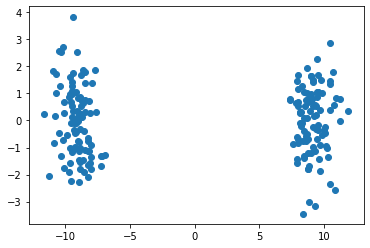

In [218]:
pca = PCA(n_components = 2)
vecs = pca.fit_transform(x)
plt.scatter(vecs[:, 0], vecs[:, 1])

In [207]:
fkl = []
bkl = []

for i in range(1, 20):
        print(i)
        sbfw = SensitivityBasedFW(x)

        na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.ones(1 + 4 * d),
          "S": 150,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "Laplace",
          "num_clusters": 3,
          "R": 1,
          "MCMC_subs_size": 30}

        w, I = sbfw.run(k = i, likelihood_gram_matrix = None, 
                        norm = "2", norm_attributes = na)

        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w)

        fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
        bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


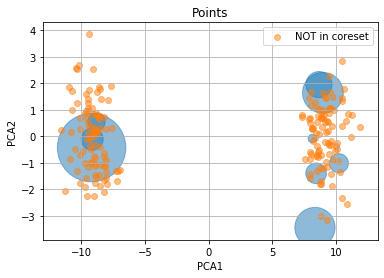

In [210]:
plot_points(x, I, w)

In [224]:
fkl = []
bkl = []

for i in range(1, 20):
        print(i)
        svi = SparseVI(x)

        na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.ones(1 + 4 * d),
          "S": 150,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "MCMC",
          "num_clusters": 3,
          "R": 1,
          "MCMC_subs_size": 30,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.ones(1 + 4 * d)}

        w, I = svi.run(k = i, likelihood_gram_matrix = None, 
                   norm_attributes = na, T = 100, gamma_func = lambda x : 1 / x)

        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w)

        fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
        bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


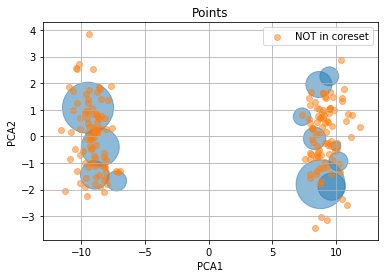

In [225]:
plot_points(x, I, w)

## 3. Parallelization

In [7]:
fkl = []
bkl = []

for i in range(1, 90):
    sbfw = SensitivityBasedFW(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": int(0.3 * len(x))}
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

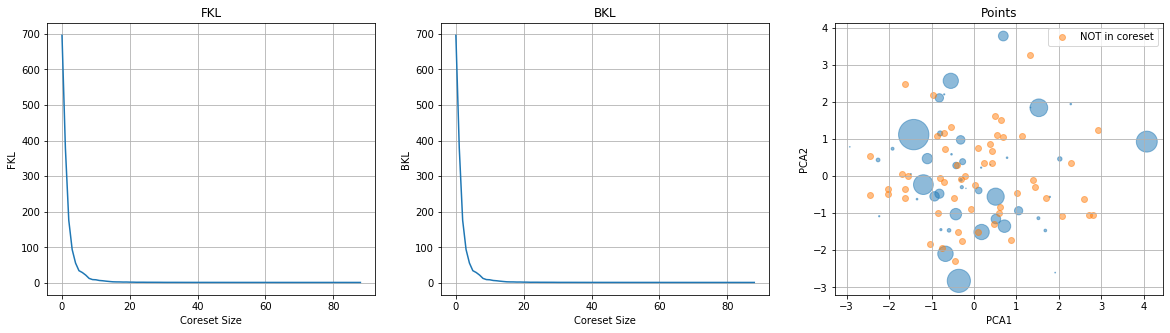

In [8]:
plot_results(fkl, bkl, x, I, w)

In [ ]:
# sum

In [7]:
fkl = []
bkl = []

for i in range(90):
    psbfw = ParallelSensitivityBasedFW(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": int(0.3 * len(x))}
    w, I = psbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

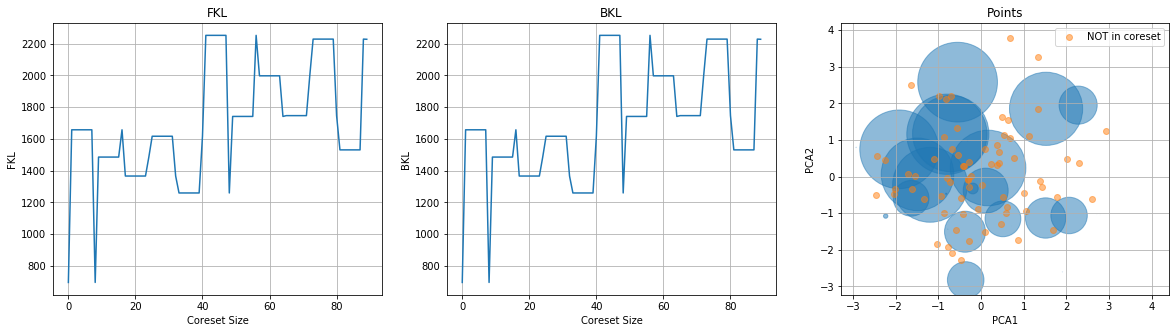

In [8]:
plot_results(fkl, bkl, x, I, w)

In [ ]:
# mean

In [7]:
fkl = []
bkl = []

for i in range(90):
    psbfw = ParallelSensitivityBasedFW(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": int(0.3 * len(x))}
    w, I = psbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

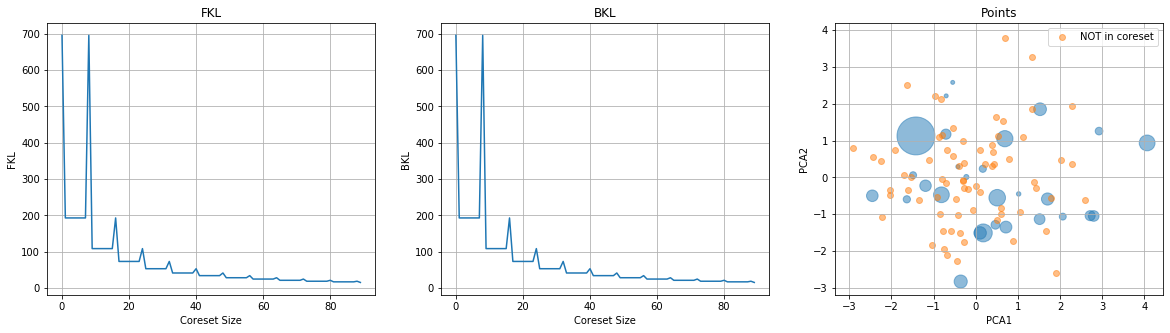

In [8]:
plot_results(fkl, bkl, x, I, w)

In [ ]:
# max

In [7]:
fkl = []
bkl = []

for i in range(90):
    psbfw = ParallelSensitivityBasedFW(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": int(0.3 * len(x))}
    w, I = psbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

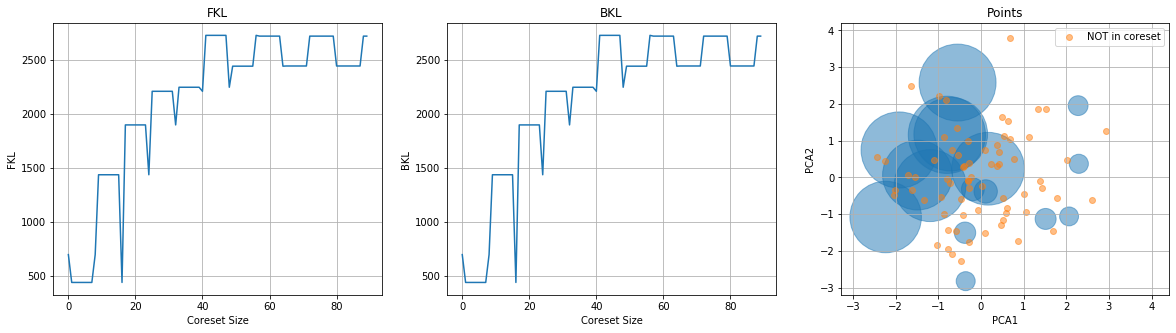

In [8]:
plot_results(fkl, bkl, x, I, w)

In [ ]:
# time

In [ ]:
# N = 500, d = 20

In [10]:
fkl = []
bkl = []
times = []

for i in range(1, 250):
    t = time.time()
    sbfw = SensitivityBasedFW(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": int(0.3 * len(x))}
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    times.append(time.time() - t)

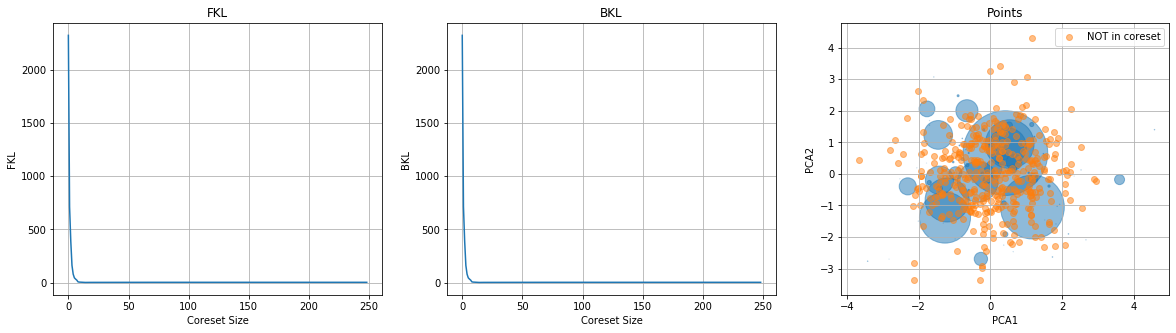

In [11]:
plot_results(fkl, bkl, x, I, w)

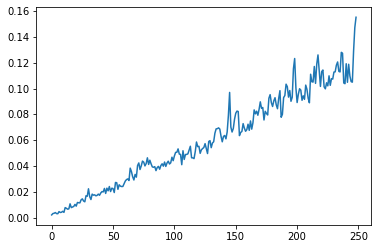

In [12]:
plt.plot(times)

In [7]:
fkl = []
bkl = []
ptimes = []

for i in range(1, 150):
    print(i)
    t = time.time()
    psbfw = ParallelSensitivityBasedFW(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": int(0.3 * len(x))}
    w, I = psbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    ptimes.append(time.time() - t)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


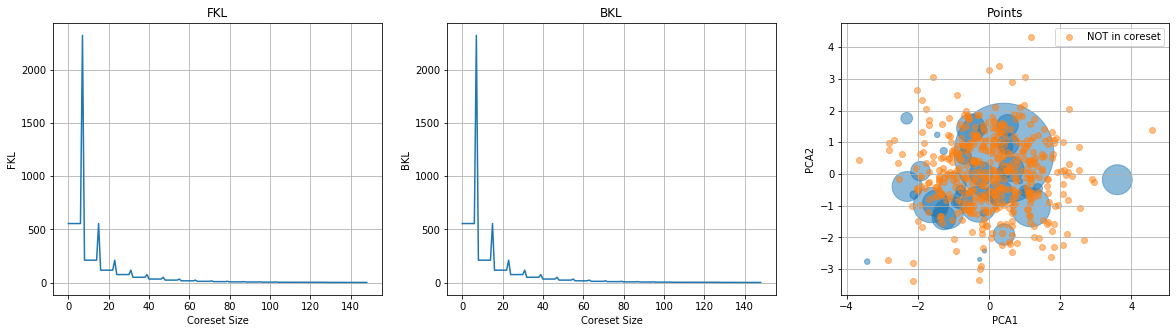

In [8]:
plot_results(fkl, bkl, x, I, w)

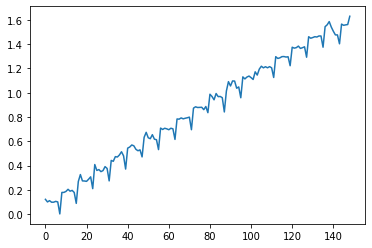

In [9]:
plt.plot(ptimes)

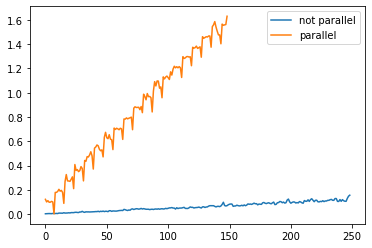

In [14]:
plt.plot(times, label = 'not parallel')
plt.plot(ptimes, label = 'parallel')
plt.legend()

In [ ]:
# time 
# N = 10000
# d = 200
# coreset = 1000

In [7]:
t = time.time()
psbfw = ParallelSensitivityBasedFW(x)
na = {"log_likelihood": log_likelihood,
  "log_likelihood_start_value": np.ones(2 * d),
  "S": 150,
  "log_likelihood_gradient": grad_log_likelihood,
  "approx": "Laplace",
  "MCMC_subs_size": int(0.3 * len(x))}
w, I = psbfw.run(k = 1000, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)

# Calculate posterior approximation
sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
mu_hat = sigma_hat @ (mu_0 + x.T @ w)

print(f"FKL: {gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)}")
print(f"BKL: {gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)}")
print(f"Time: {time.time() - t}")

FKL: 6.937897907350596
BKL: 6.9592779197947365
Time: 1765.2076268196106


In [8]:
t = time.time()
sbfw = SensitivityBasedFW(x)
na = {"log_likelihood": log_likelihood,
  "log_likelihood_start_value": np.ones(2 * d),
  "S": 150,
  "log_likelihood_gradient": grad_log_likelihood,
  "approx": "Laplace",
  "MCMC_subs_size": int(0.3 * len(x))}
w, I = sbfw.run(k = 1000, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)

# Calculate posterior approximation
sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
mu_hat = sigma_hat @ (mu_0 + x.T @ w)

print(f"FKL: {gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)}")
print(f"BKL: {gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)}")
print(f"Time: {time.time() - t}")

FKL: 0.9834375842487049
BKL: 0.9846603486741827
Time: 123.94034910202026
